# **The Great Energy Predicator - EDA**

The American Society of Heating, Refrigerating and Air-Conditioning Engineers was established more than 125 ago. It is one of the leading forces in advanced heating, ventilation, air conditioning and refrigeration (HVAC&R) systems and it is operating in 132 countries worldwide. ASHRAE funds multiple research projects to improve energy efficency, technical standards, sustainable development etc. 

# **Table of content**

* [Introduction](#1)
* [Initial data preperation](#2)
* [Missing data check](#3)
* [Initial outlier detection](#4)
* [EDA](#5)
* [Square feet and EE](#6)
* [Linear correlations](#7)
* [Categorical differences in energy usage](#8)
* [Building data analysis](#9)
* [Temperature data analysis](#10)

<a id="1"> </a>
# **Introduction**

The purpose of this exploratory data analysis is to provide some interesting insights and analyse the effect different variables have on energy consumption.  My personal goal is to use this notebook to further improve my data visualization skills and experiment with some additional plotting options.

<a id="2"></a>
# **Initial data preperation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import datetime as dt
import gc

plt.style.use('fivethirtyeight')

Below is a very useful memory reduction script with a link to the original notebook. It reduces the memory of the CSV files by altering the data type for each column. I highly suggest you keep it in mind when running larger datasets.

In [2]:
#Memory reduction script
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [3]:
#Importing of files and the reduction of memory usage
print('-' * 80)
print('train')
train = import_data("../input/ashrae-energy-prediction/train.csv")

print('-' * 80)
print("building_metadata")
building_metadata = import_data("../input/ashrae-energy-prediction/building_metadata.csv")

print('-' * 80)
print("weather_train")
weather_train = import_data("../input/ashrae-energy-prediction/weather_train.csv")

--------------------------------------------------------------------------------
train
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
--------------------------------------------------------------------------------
building_metadata
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
--------------------------------------------------------------------------------
weather_train
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [4]:
df_train = train.merge(building_metadata, on="building_id", how="left")
df_train = df_train.merge(weather_train, on=["site_id","timestamp"], how="left")

df_train = df_train.sort_values(by=["timestamp"])
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"].astype("object"))

df_train = df_train.set_index(df_train["timestamp"])
df_train = df_train.drop(["timestamp"],axis=1)


#Rename for easier ploting
metermap = {0: "Electricity", 1: "Chilledwater", 2: "Steam", 3: "Hotwater"}
df_train["meter"].replace(metermap,inplace=True)


gc.collect()

del building_metadata,weather_train

<a id="3"></a>

# **Missing data check**

In [5]:
df_train.isnull().sum()

building_id                  0
meter                        0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

Missingno is one of the best plots to visualize missing data. It offers a wide variety of plots and options. For example, the nullity_filter offers the ability to only present the columns that have a certain percentage of missing data. This is very useful for us since the combined dataset has a lot of columns and displaying them all would result in

4

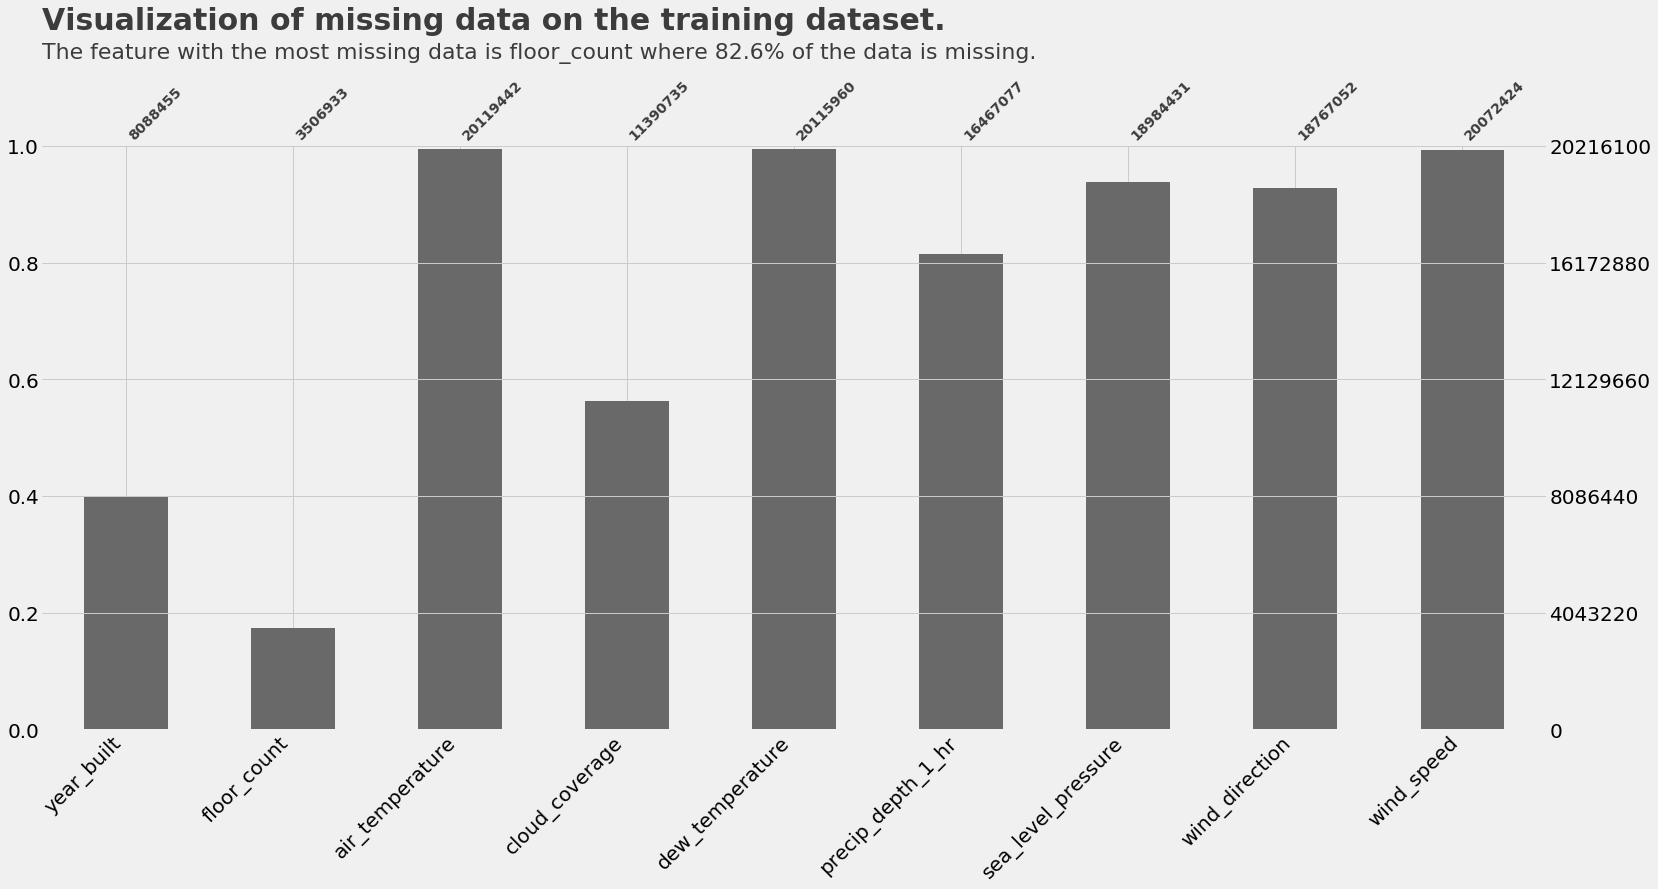

In [6]:
fig,ax = plt.subplots(figsize=(12,5))

#Plot
filtered_data = msno.nullity_filter(df_train, filter='bottom', n=15, p=0.999)
msno.bar(filtered_data,fontsize=20)

plt.xticks(fontsize=14, weight="bold", alpha=0.75)

#Title
ax.text(x=-0.5,y=1.2,s="Visualization of missing data on the training dataset.",fontsize=30,weight="bold",alpha=0.75)
ax.text(x=-0.5,y=1.15,s="The feature with the most missing data is floor_count where 82.6% of the data is missing.",fontsize=22,alpha=0.75)
#plt.savefig("missing_values_plot.png")

del filtered_data
gc.collect()

<a id="4"><a/>
# **Initial outlier detection**

In this segment, I will do a descriptive statistical analysis of the data and visual outlier detection. For the visual outlier detection, I have to give a shoutout to the Kaggle user [Roman](https://www.kaggle.com/nroman). You have inspired me to do my own take on this.

In [7]:
pd.options.display.float_format = '{:20,.2f}'.format
df_train.describe()

building_id        meter_reading              site_id  \
count        20,216,100.00        20,216,100.00        20,216,100.00   
mean                799.28             1,988.69                 7.99   
std                 426.91           153,215.94                 5.10   
min                   0.00                 0.00                 0.00   
25%                 393.00                18.30                 3.00   
50%                 895.00                78.78                 9.00   
75%               1,179.00               267.98                13.00   
max               1,448.00        21,904,700.00                15.00   

               square_feet           year_built          floor_count  \
count        20,216,100.00         8,088,455.00         3,506,933.00   
mean            107,782.98                  nan                  nan   
std             117,142.44                  nan                 0.00   
min                 283.00             1,900.00                 1.00   
25%              32,527.00             1,951.00                 1.00   
50%              72,709.00             1,969.00                 3.00   
75%             139,113.00             1,993.00                 6.00   
max             875,000.00             2,017.00                26.00   

           air_temperature       cloud_coverage      dew_temperature  \
count        20,119,442.00        11,390,735.00        20,115,960.00   
mean                   nan                  nan                  nan   
std                   0.00                 0.00                 0.00   
min                 -28.91                 0.00               -35.00   
25%                   8.60                 0.00                 0.00   
50%                  16.70                 0.00                 8.90   
75%                  24.09                 4.00                16.09   
max                  47.19                 9.00                26.09   

         precip_depth_1_hr   sea_level_pressure       wind_direction  \
count        16,467,077.00        18,984,431.00        18,767,052.00   
mean                   nan                  nan                  nan   
std                    nan                  nan                  nan   
min                  -1.00               968.00                 0.00   
25%                   0.00             1,011.50                70.00   
50%                   0.00             1,016.00               180.00   
75%                   0.00             1,020.50               280.00   
max                 343.00             1,046.00               360.00   

                wind_speed  
count        20,072,424.00  
mean                   nan  
std                   0.00  
min                   0.00  
25%                   2.10  
50%                   3.10  
75%                   4.60  
max                  19.00

In [8]:
#Resample daily
daily_consumption = df_train["meter_reading"].resample("D").mean()
#Resample monthly
#monthly_consumption = df_train["meter_reading"].resample("M").mean()
#Resample hourly
hourly_consumption = df_train["meter_reading"].resample("H").mean()

gc.collect()

0

6437

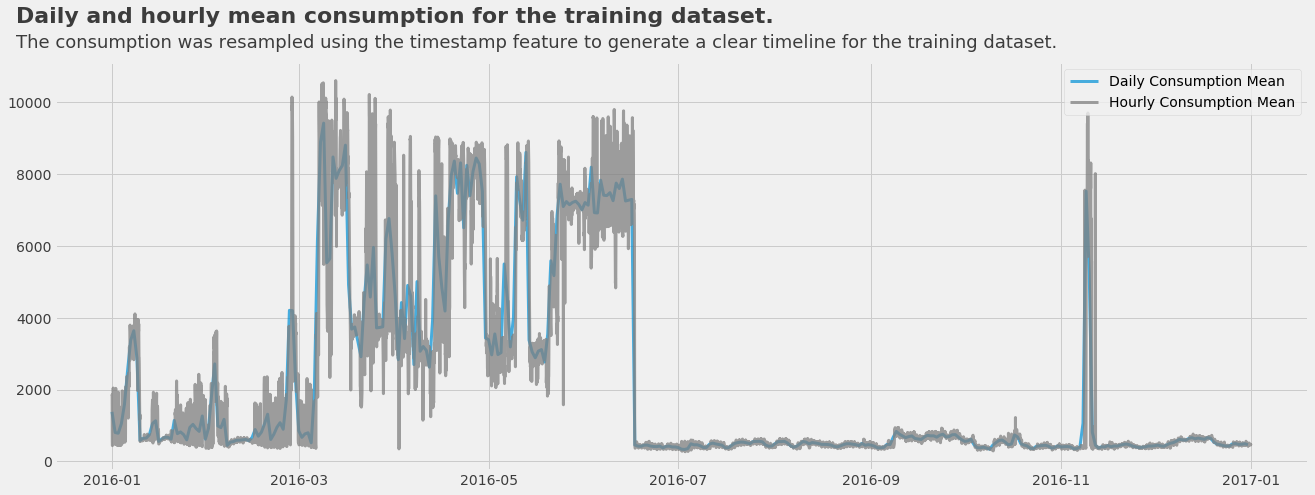

In [9]:
fig, ax = plt.subplots(figsize = (20,7))

#PLot
plt.plot(daily_consumption,linestyle="solid",linewidth=3, alpha=0.7, label="Daily Consumption Mean")
plt.plot(hourly_consumption,linestyle="solid",color="gray",linewidth=3 ,alpha=0.75,label="Hourly Consumption Mean")
plt.xticks(fontsize=14,alpha=0.75)
plt.yticks(fontsize=14,alpha=0.75)

plt.legend(loc="upper right")

#Title
ax.text(x=dt.date(2015, 12, 1),y=12200,s="Daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)
ax.text(x=dt.date(2015, 12, 1),y=11500,s="The consumption was resampled using the timestamp feature to generate a clear timeline for the training dataset. ", fontsize="18",alpha=0.75)

gc.collect()

Something is obviously not alright with the daily and monthly consumption data. The numbers are too high for a mean consumption and this suggests that there is an outlier that is heavily affecting the graph. I will do a step by step visual analysis to narrow down the problematic meter.

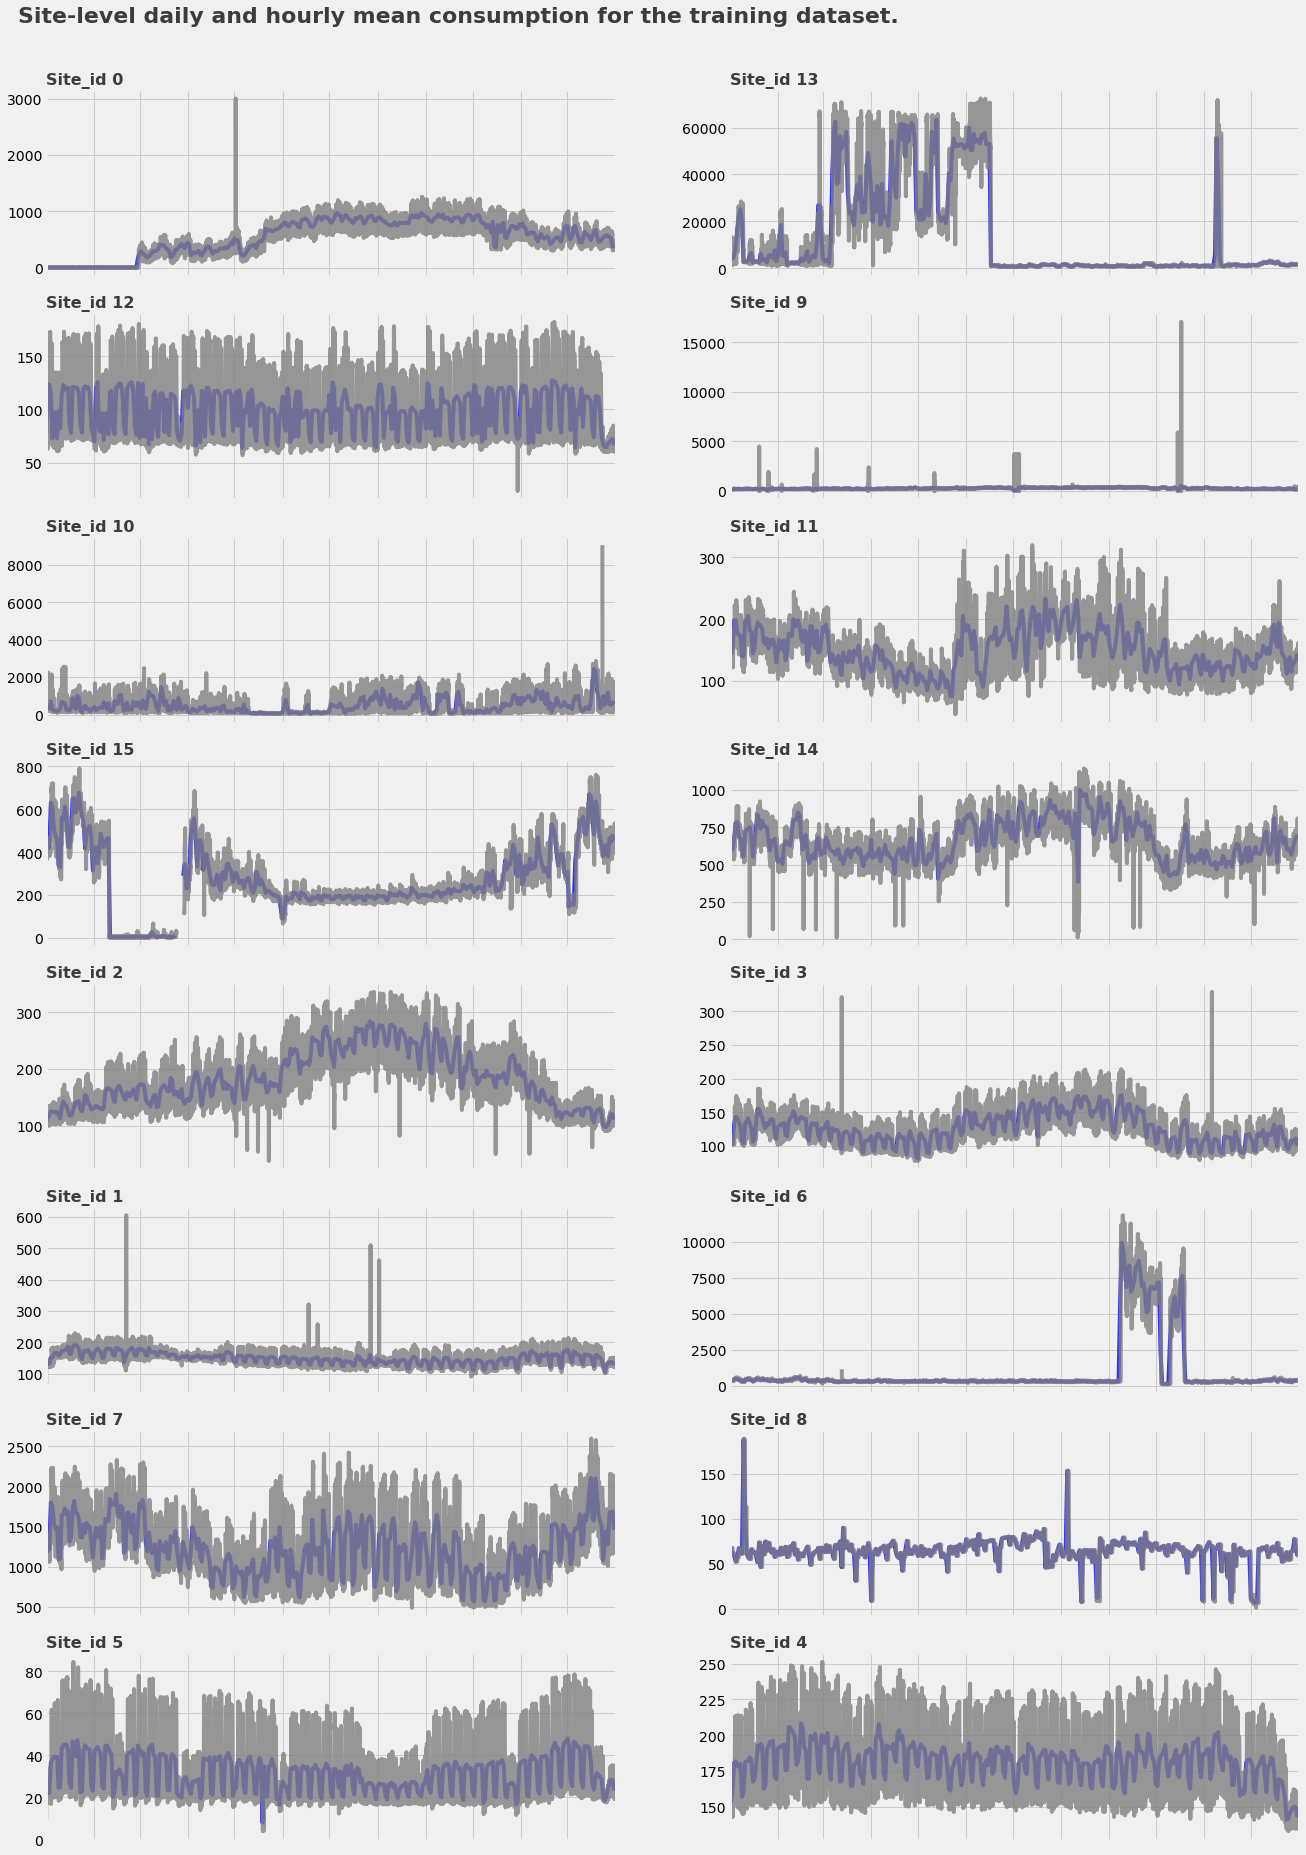

In [10]:
unique_site = df_train["site_id"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharex=True)

#Plot
for number, site in enumerate(unique_site, start=1):
    
    site_d = df_train[df_train["site_id"] == site]["meter_reading"].resample("D").mean()
    site_h = df_train[df_train["site_id"] == site]["meter_reading"].resample("H").mean()
    
    plt.subplot(8,2,number)
    site_d.plot(linestyle="solid", color="blue", alpha=0.8, label="Daily Mean")
    plt.tick_params(labelbottom=False)
    site_h.plot(linestyle="solid", color="grey", alpha=0.8, label="Hourly Mean")
    plt.tick_params(labelbottom=False)
    plt.title('Site_id {}'.format(site), loc="left", fontsize=16, alpha=0.75, weight="bold")
    plt.xlabel("")
#Title
plt.text(x=dt.date(2014, 10, 1),y=1400,s="Site-level daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)   
#plt.savefig("consumption_per_site_id.png")
    
gc.collect()
del unique_site

I am going to take four out of the above-presented sites for a deeper look. Two of which (site 0 and site 10) have a fairly normal-looking consumption. The other two sites (site 9 and site 13) have suspicious-looking consumption when compared to the other sites.

Looking at a normal consumption distribution will give me a good initial baseline about what can or can't be expected from consumption data.

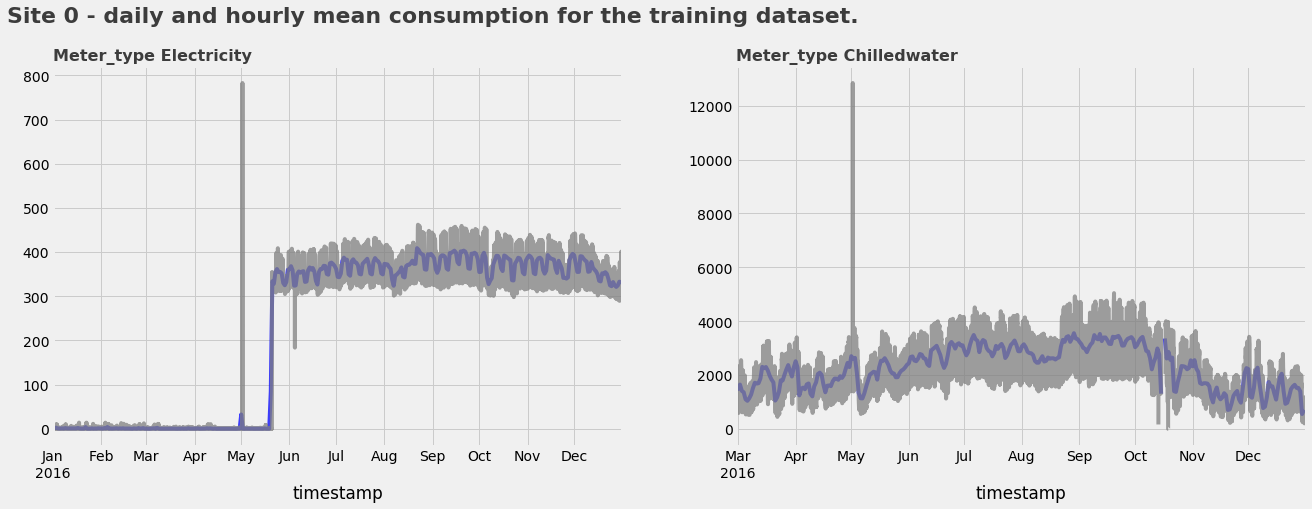

In [11]:
site = 0
unique_meter = df_train[df_train["site_id"] == site]["meter"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number, meter in enumerate(unique_meter,start=1):
    
    meter_d = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("D").mean()
    meter_h = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("H").mean()
    
    plt.subplot(4,2,number)
    meter_d.plot(linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
    meter_h.plot(linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")
    
    plt.title("Meter_type {}".format(meter), loc="left", fontsize=16, alpha=0.75, weight="bold")

#Title

plt.text(x=dt.date(2015, 2, 1),y=15100,s="Site 0 - daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)
    
gc.collect()
del unique_meter

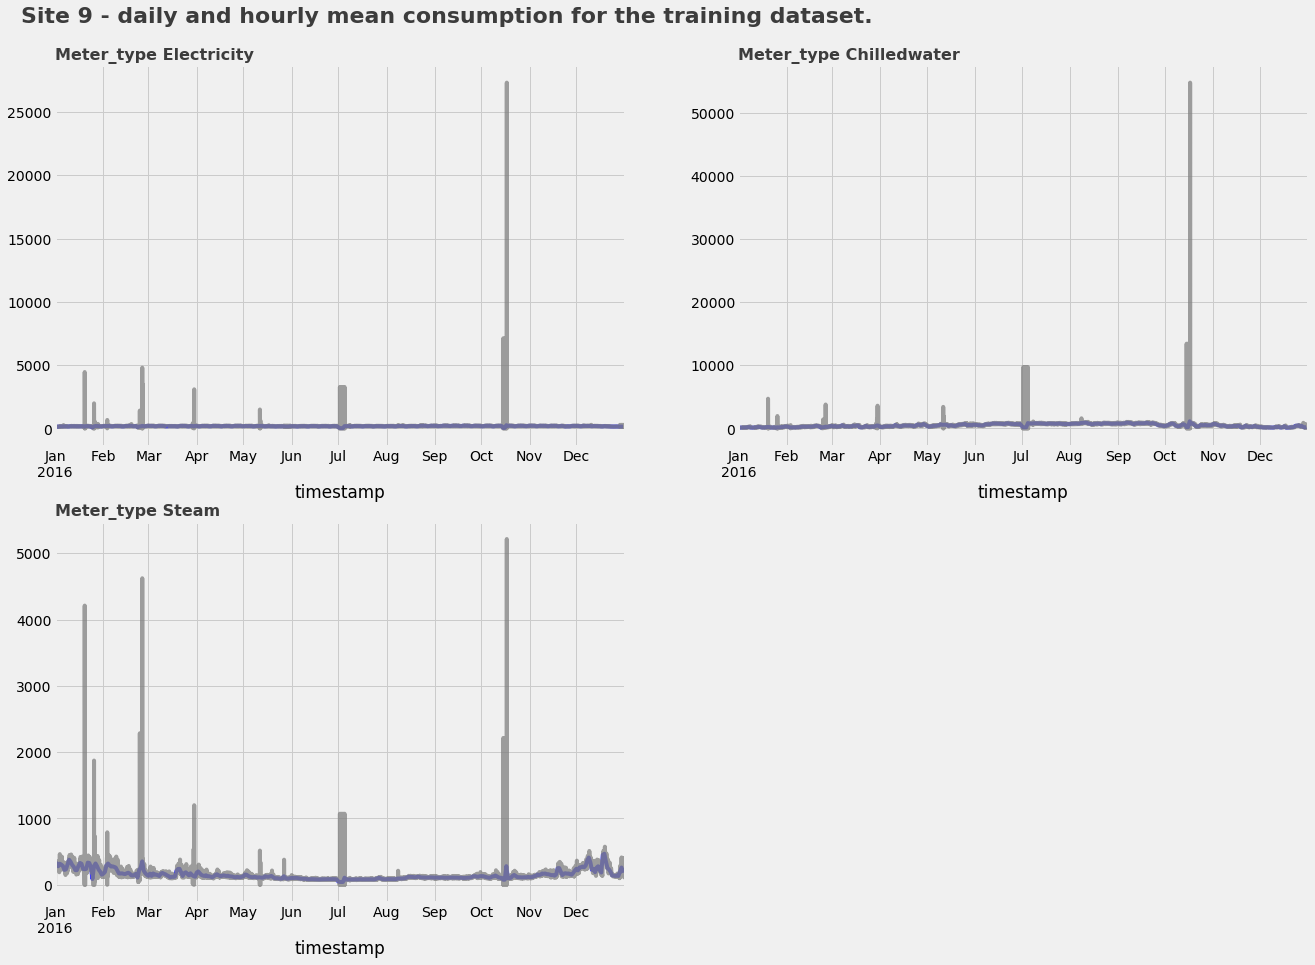

In [12]:
site = 9
unique_meter = df_train[df_train["site_id"] == site]["meter"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number, meter in enumerate(unique_meter,start=1):
    
    meter_d = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("D").mean()
    meter_h = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("H").mean()
    
    plt.subplot(4,2,number)
    meter_d.plot(linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
    meter_h.plot(linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")
    
    plt.title("Meter_type {}".format(meter), loc="left", fontsize=16, alpha=0.75,weight="bold")
#Title
plt.text(x=dt.date(2015, 12, 10),y=13000,s="Site 9 - daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)    

gc.collect()
del unique_meter

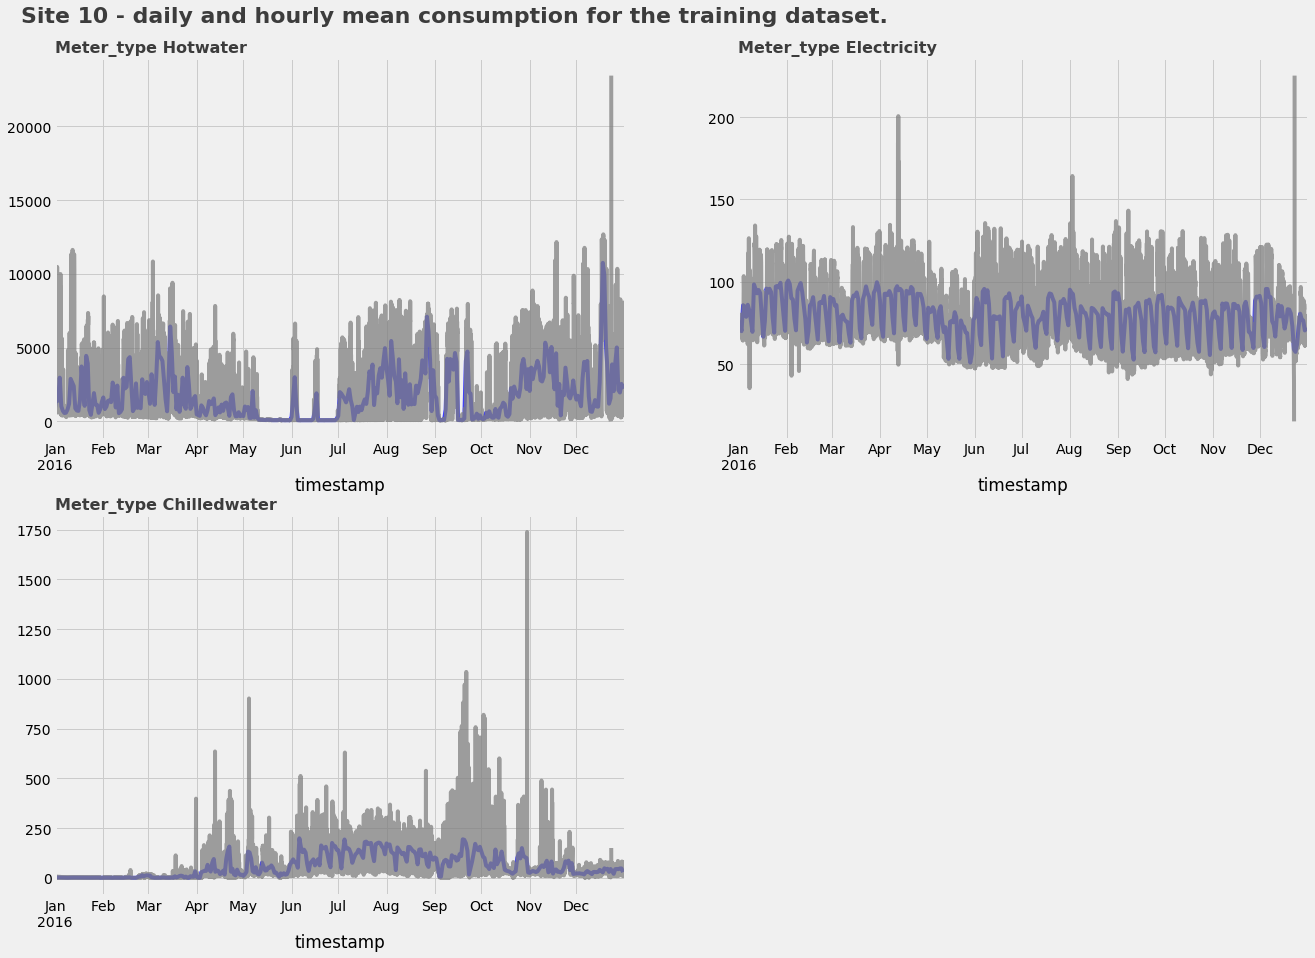

In [13]:
site = 10
unique_meter = df_train[df_train["site_id"] == site]["meter"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number,meter in enumerate(unique_meter,start=1):
    
    meter_d = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("D").mean()
    meter_h = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("H").mean()
    
    plt.subplot(4,2,number)
    meter_d.plot(linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
    meter_h.plot(linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")
    
    plt.title("Meter_type {}".format(meter), loc="left", fontsize=16, alpha=0.75, weight="bold")

#Title
plt.text(x=dt.date(2015, 12, 10),y=4300,s="Site 10 - daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)

gc.collect()
del unique_meter

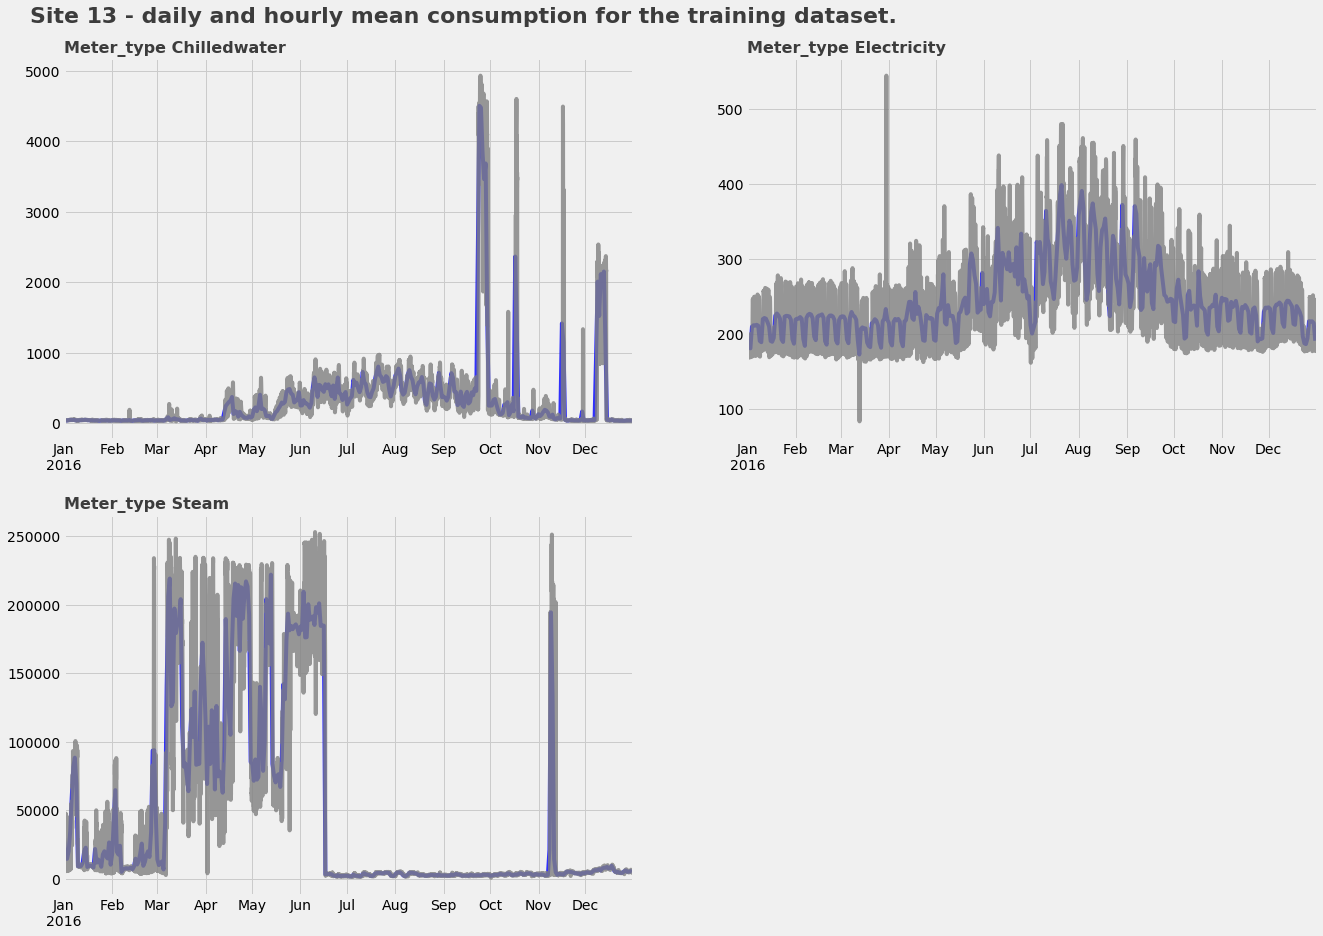

In [14]:
site = 13
unique_meter = df_train[df_train["site_id"] == site]["meter"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number, meter in enumerate(unique_meter,start=1):
    
    meter_d = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("D").mean()
    meter_h = df_train[(df_train["meter"] == meter) & (df_train["site_id"] == site)]["meter_reading"].resample("H").mean()
    
    plt.subplot(4,2,number)
    meter_d.plot(linestyle="solid", color="blue", alpha=0.8, label="Daily Mean")
    meter_h.plot(linestyle="solid", color="grey", alpha=0.8, label="Hourly Mean")
    plt.xlabel("")
    
    plt.title("Meter_type {}".format(meter), loc="left", fontsize=16,weight="bold",alpha=0.75)

#Title
plt.text(x=dt.date(2015, 12, 10),y=625000,s="Site 13 - daily and hourly mean consumption for the training dataset.", weight="bold", fontsize="22",alpha=0.75)
#plt.savefig("consumption_per_site13_meter.png")

gc.collect()
del unique_meter

The major outlier that is effecting the whole dataset is most definitely on the site 13 Steam meter.

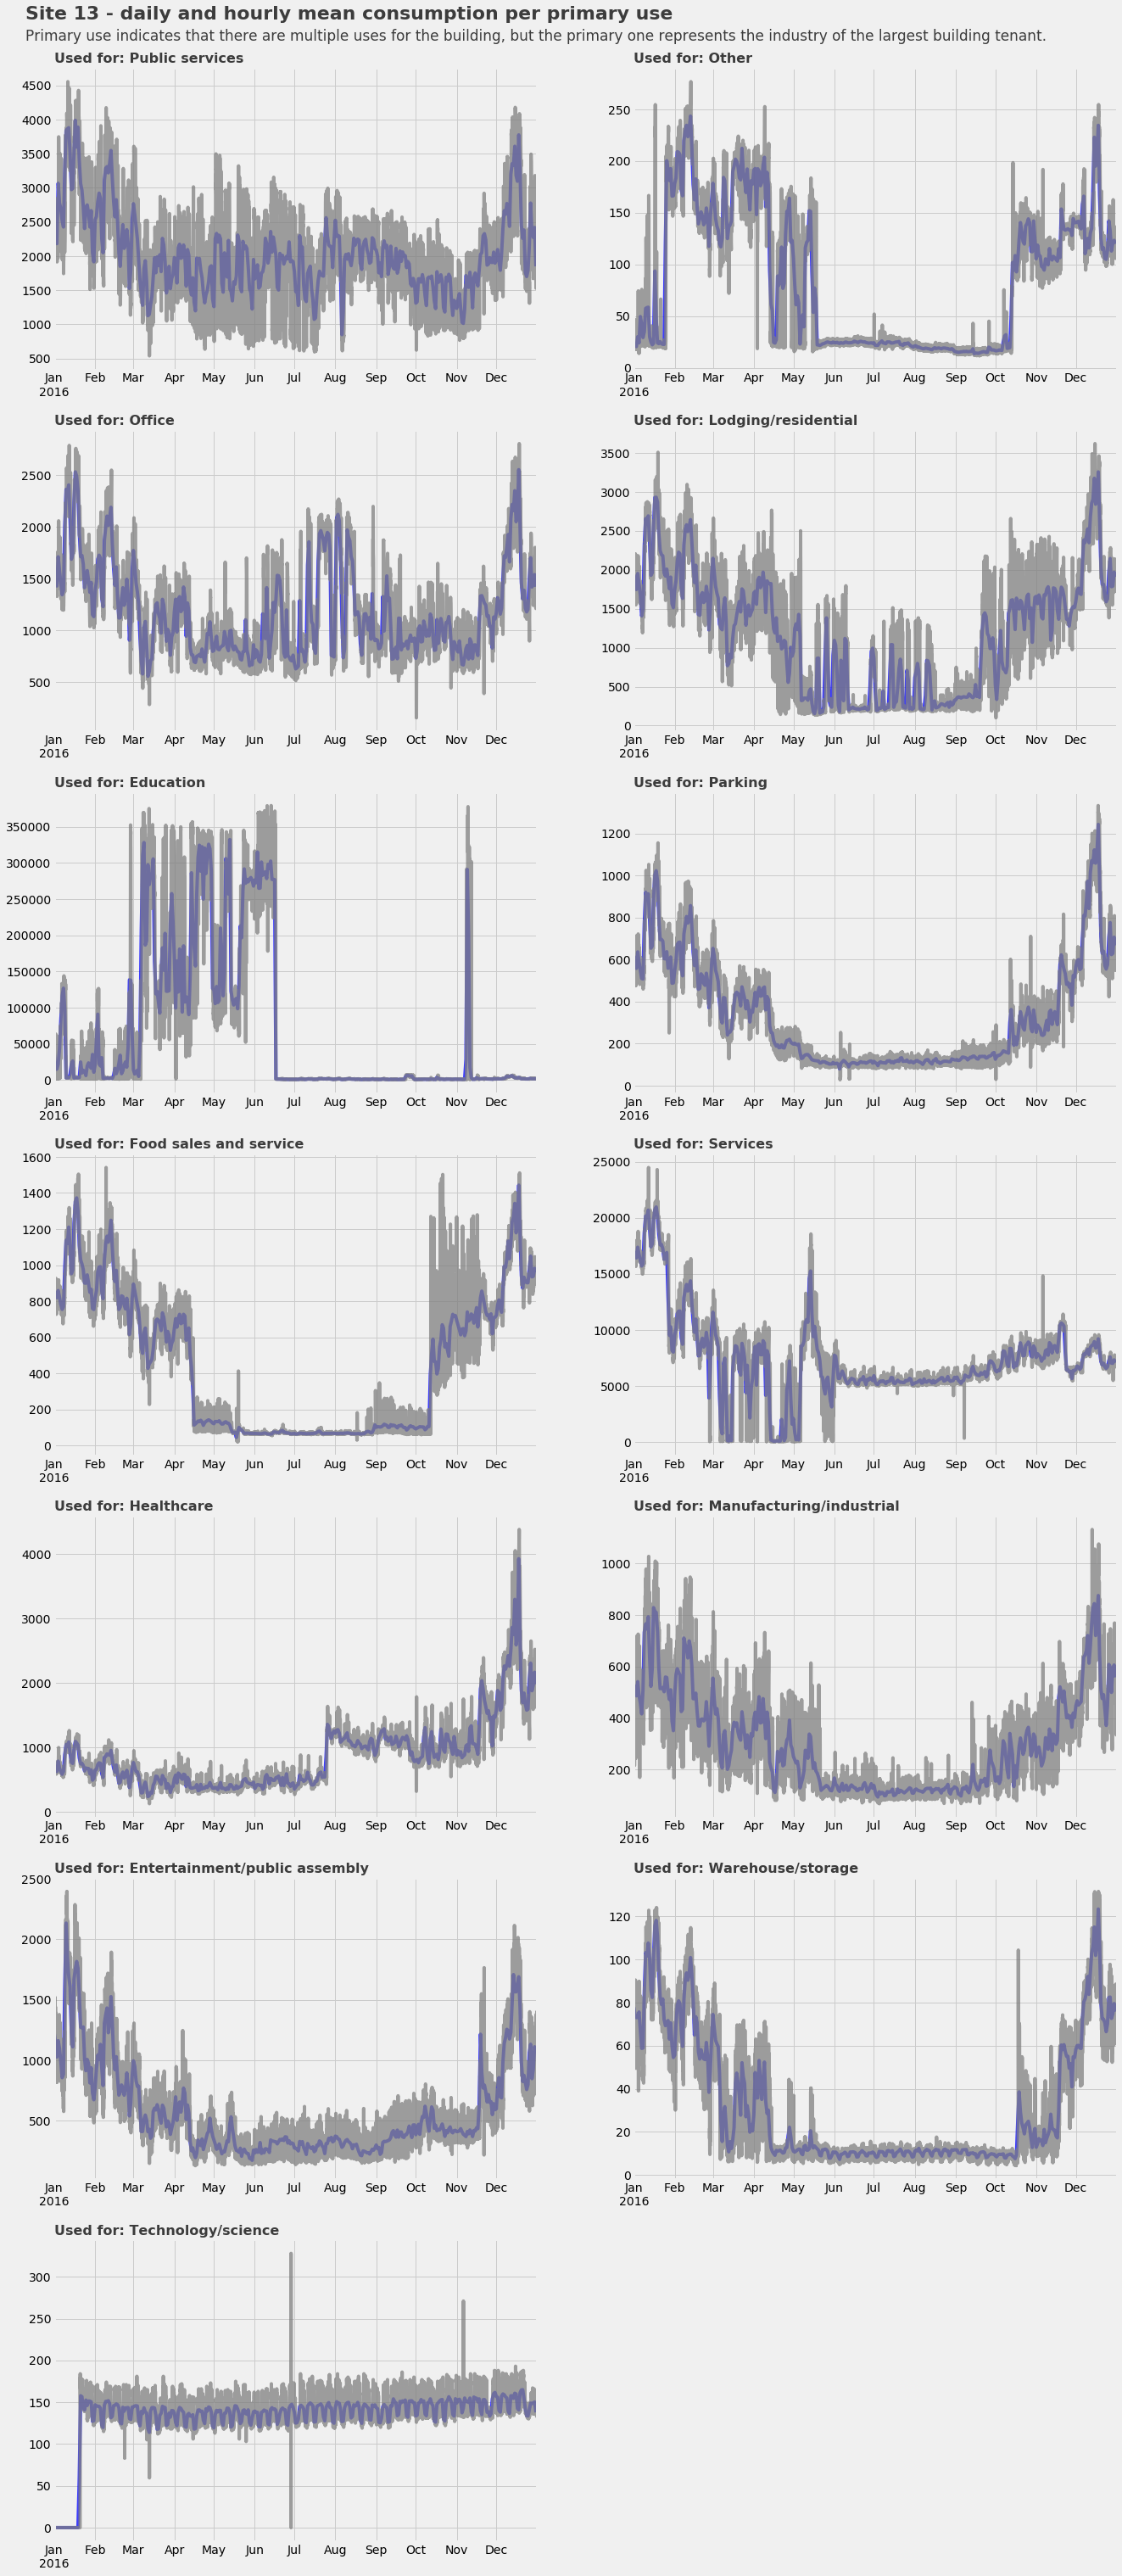

In [15]:
site = 13
unique_use = df_train[df_train["site_id"] == site]["primary_use"].unique()

fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number,use in enumerate(unique_use,start=1):
     
    use_d = df_train[(df_train["primary_use"] == use) & (df_train["site_id"] == site)]["meter_reading"].resample("D").mean()
    use_h = df_train[(df_train["primary_use"] == use) & (df_train["site_id"] == site)]["meter_reading"].resample("H").mean()
    
    plt.subplot(7,2,number)
    plt.subplots_adjust(bottom=0.15, top=1.5)
    use_d.plot(linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
    use_h.plot(linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")
    plt.xlabel("")
    
    plt.title("Used for: {}".format(use), loc="left", fontsize=16, weight="bold", alpha=0.75)

#Title
plt.text(x=dt.date(2015, 12, 10),y=3000,s="Site 13 - daily and hourly mean consumption per primary use", weight="bold", fontsize="22",alpha=0.75)
plt.text(x=dt.date(2015, 12, 10),y=2975,s="Primary use indicates that there are multiple uses for the building, but the primary one represents the industry of the largest building tenant.", fontsize="17",alpha=0.75)
    
plt.savefig("consumption_per_site_meter_use.png")
        
gc.collect()
del unique_use

The above plot narrows down further by eliminating every building that isnt primarily used for education.

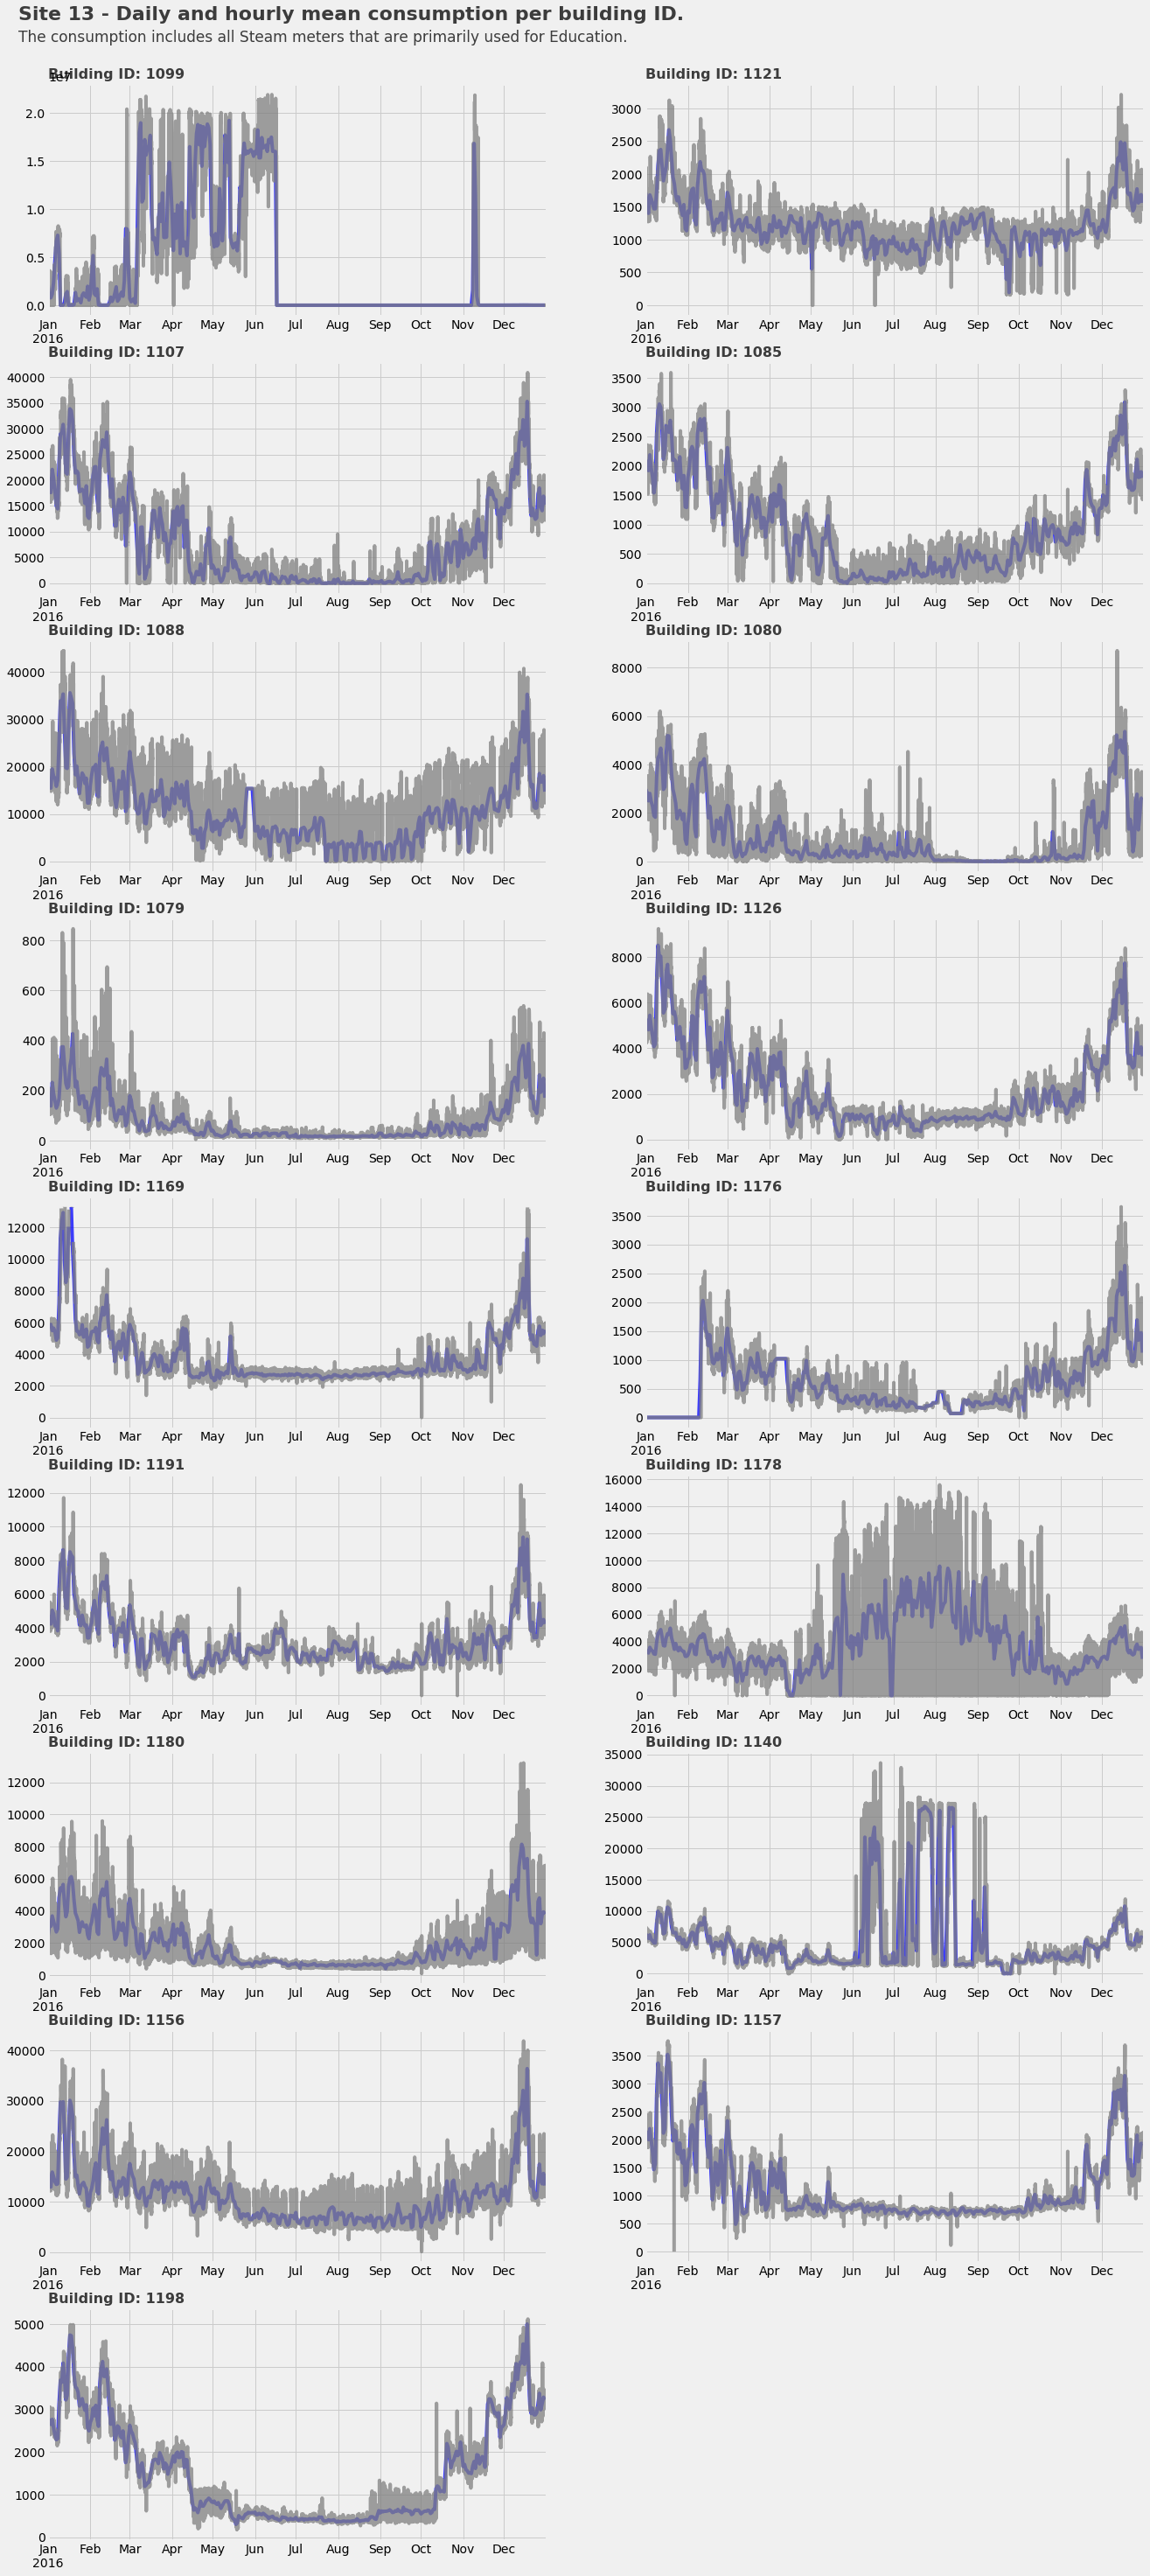

In [16]:
site = 13
buildings = df_train[(df_train["site_id"] == 13) & (df_train["primary_use"] == "Education") 
         & (df_train["meter"] == "Steam")]["building_id"].unique()


fig, ax = plt.subplots(figsize=(20,30),sharey=True)

for number,build in enumerate(buildings,start=1):
    
    
    build_d = df_train[(df_train["primary_use"] == "Education") & (df_train["site_id"] == 13) & (df_train["meter"] == "Steam") &
                      (df_train["building_id"] == build) & (df_train["building_id"]==build)]["meter_reading"].resample("D").mean()
    
    build_h = df_train[(df_train["primary_use"] == "Education") & (df_train["site_id"] == 13) &
                      (df_train["meter"] == "Steam") & (df_train["building_id"]==build)]["meter_reading"].resample("H").mean()
    
    plt.subplot(9,2,number)
    plt.subplots_adjust(bottom=0.20, top=1.5)
    build_d.plot(linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
    build_h.plot(linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")
    plt.xlabel("")
    
    plt.title("Building ID: {}".format(build), loc="left", fontsize=16, weight="bold", alpha=0.75)
    
#Title   
plt.text(x=dt.date(2015, 12, 10),y=59000,s="Site 13 - Daily and hourly mean consumption per building ID.", weight="bold", fontsize="22",alpha=0.75)
plt.text(x=dt.date(2015, 12, 10),y=58500,s="The consumption includes all Steam meters that are primarily used for Education.", fontsize="17",alpha=0.75)
#plt.savefig("consumption_per_site_id_meter_use_building.png")
gc.collect()
del buildings

In [17]:
df_train_clean = df_train[~((df_train["building_id"] == 1099) & (df_train["meter"]=="Steam"))]

gc.collect()
del df_train

In [18]:
new_daily_mean = df_train_clean["meter_reading"].resample("D").mean()
new_hourly_mean = df_train_clean["meter_reading"].resample("H").mean()

gc.collect()

20

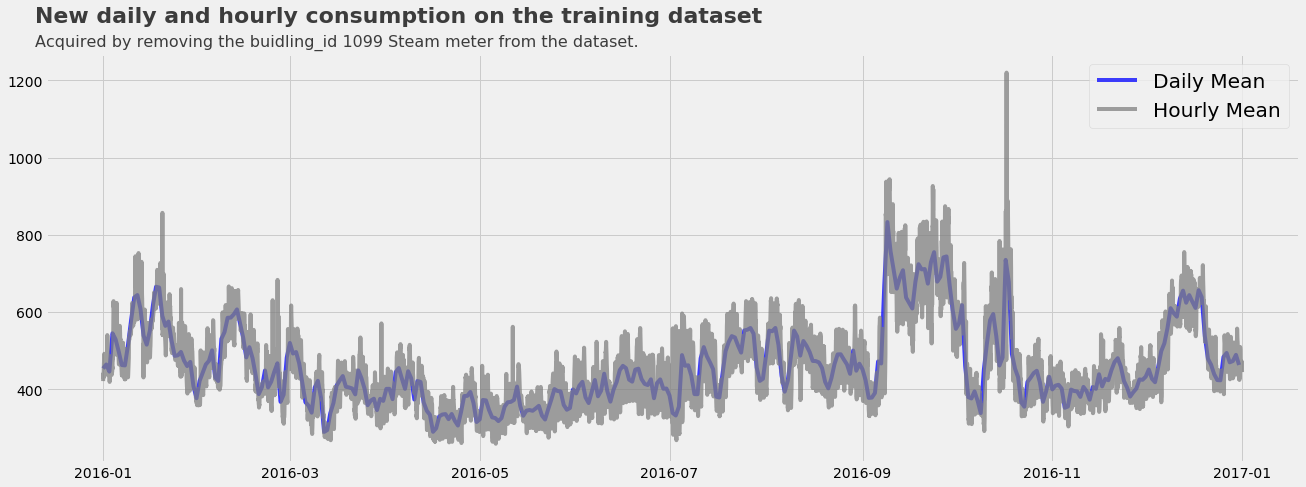

In [19]:
fig, ax = plt.subplots(figsize=(20,7))

plt.plot(new_daily_mean, linestyle="solid", color="blue", alpha=0.75, label="Daily Mean")
plt.plot(new_hourly_mean, linestyle="solid", color="grey", alpha=0.75, label="Hourly Mean")


plt.text(x=dt.date(2015, 12, 10),y=1350,s="New daily and hourly consumption on the training dataset", weight="bold", fontsize="22",alpha=0.75)
plt.text(x=dt.date(2015, 12, 10),y=1290,s="Acquired by removing the buidling_id 1099 Steam meter from the dataset.", fontsize="16",alpha=0.75)
plt.legend(fontsize="x-large")
plt.savefig("new_consumption.png")

gc.collect()

del new_daily_mean, new_hourly_mean

The new plot looks a lot better than its previous counterpart. However the data overall still cannot be considered clean. The issue I have found that prevents one-method-for-all approaches is the heterogenic nature of the dataset. Each of the buildings is an entity on its own with a unique consumption profile that prevents general solutions. This is especially true of electricity meters because they are not affected by temperature in the same way the HVAC meters are.

While temperature has a role in the profiling of electricity meters its minor compared to internal factors that dictate its consumption. The approach I will try while producing a model is to plot the electricity consumption for each building and mark the outliers manually. 

# **<a id="5"> EDA </a>**

Now that the initial cleaning of the data is finished, I am going to take a look at some interesting features of the dataset and their relationship with the target variable. 

**<a id="6"> Square feet and EE </a>**

Square feet is interesting to look at. The data is heavily left-skewed since there tend to be more small/medium buildings then skyscrapers. Because of this, we need to do a logarithmic transformation of the data that will even out the distribution.

Text(4.5, 6000000, 'Log transformation was used to address the initial right-skewed data distribution.')

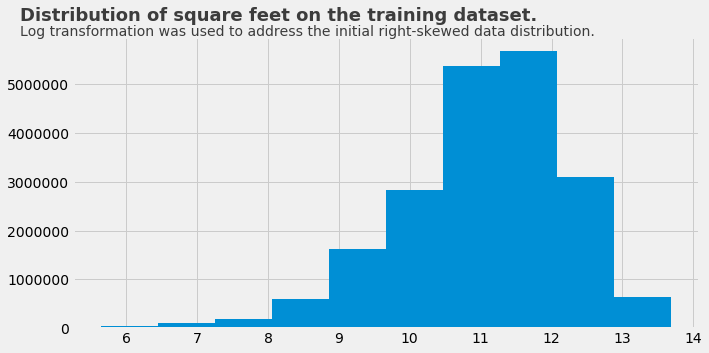

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

plt.hist(np.log1p(df_train_clean["square_feet"]))

ax.text(x=4.5,y=6300000,s="Distribution of square feet on the training dataset.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=4.5,y=6000000,s="Log transformation was used to address the initial right-skewed data distribution.", fontsize="14",alpha=0.75)

Now you will probably ask: OG, why is the square feet column interesting to look at? It's just a distribution that needs a logarithmic transformation. 

Well, it's interesting because consumption per square feet is a go-to metric in evaluating the energy efficiency of buildings. The method is slightly flawed but very useful in a lot of situations.It is usually applied after the building undergoes renovations to improve isolation. That being said, a lot of times all consumption is taken into account when calculating kWh per sq ft. However, I find that its better used when separating meter types.

In [21]:
ee = df_train_clean.groupby(["site_id","building_id","meter"]).agg({"meter_reading":"sum","square_feet":"max"})
ee["consumption_per_squaref"] = ee["meter_reading"]/ ee["square_feet"]
ee.sort_values("consumption_per_squaref",ascending=False, inplace=True)

gc.collect()

2763

0

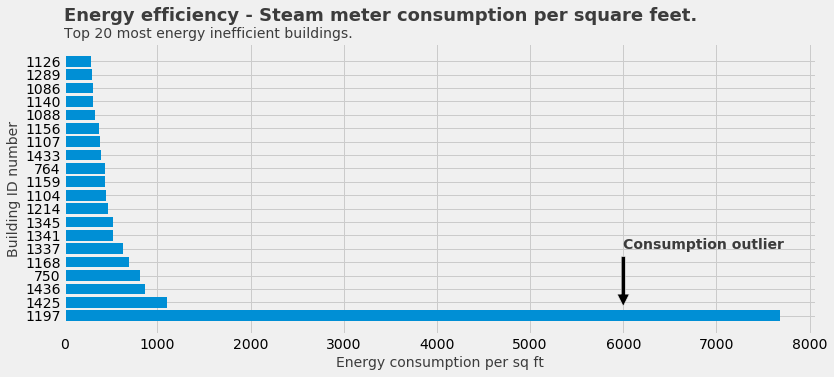

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
#Data
ee_steam = ee[ee.index.get_level_values("meter") == "Steam"]

#Plot
plt.barh(ee_steam.index.get_level_values("building_id")[:20].astype("str"),ee_steam["consumption_per_squaref"][:20])

plt.xlabel("Energy consumption per sq ft", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

ax.annotate("Consumption outlier",xy=(6000,0.5),xytext=(6000,5),arrowprops=dict(facecolor='black', shrink=0.05),weight="bold",alpha=0.75)

#Title

ax.text(x=0,y=22,s="Energy efficiency - Steam meter consumption per square feet.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.75,s="Top 20 most energy inefficient buildings.", fontsize="14",alpha=0.75)

del ee_steam

gc.collect()

4638

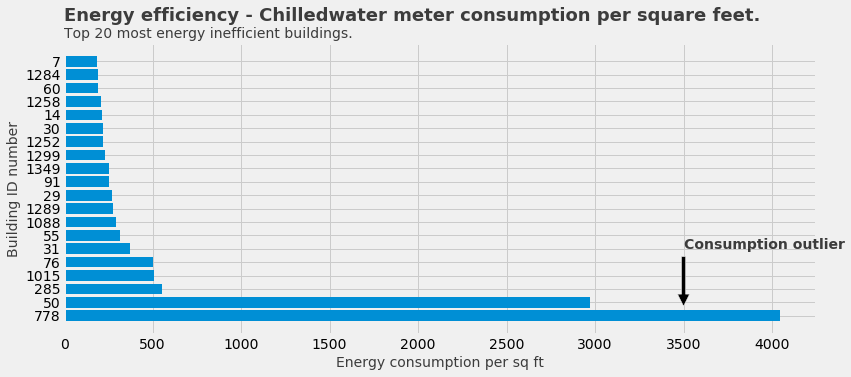

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
#Data
ee_steam = ee[ee.index.get_level_values("meter") == "Chilledwater"]

#Plot
plt.barh(ee_steam.index.get_level_values("building_id")[:20].astype("str"),ee_steam["consumption_per_squaref"][:20])

plt.xlabel("Energy consumption per sq ft", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

ax.annotate("Consumption outlier",xy=(3500,0.5),xytext=(3500,5),arrowprops=dict(facecolor='black', shrink=0.05),weight="bold",alpha=0.75)

#Title

ax.text(x=0,y=22,s="Energy efficiency - Chilledwater meter consumption per square feet.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.75,s="Top 20 most energy inefficient buildings.", fontsize="14",alpha=0.75)

del ee_steam

gc.collect()

4634

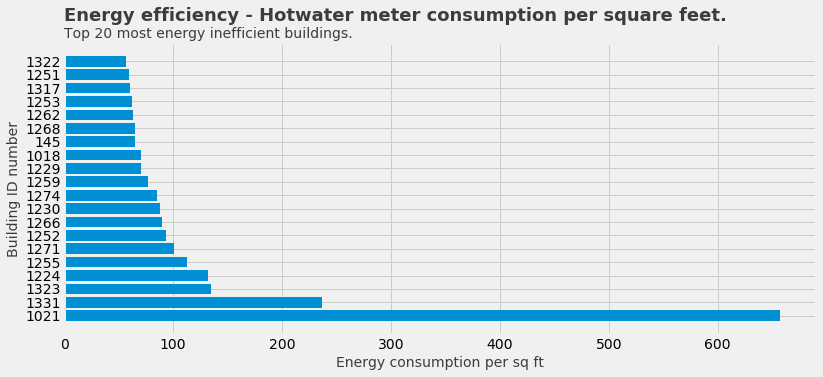

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
#Data
ee_steam = ee[ee.index.get_level_values("meter") == "Hotwater"]

#Plot
plt.barh(ee_steam.index.get_level_values("building_id")[:20].astype("str"),ee_steam["consumption_per_squaref"][:20])

plt.xlabel("Energy consumption per sq ft", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

#Title

ax.text(x=0,y=22,s="Energy efficiency - Hotwater meter consumption per square feet.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.75,s="Top 20 most energy inefficient buildings.", fontsize="14",alpha=0.75)

del ee_steam, ee

gc.collect()

I have marked some consumption outliers above that are targets for future data cleaning.

One problem with this comparison is that not all building are exposed to the same temperature. That is especially important on HVAC meters that are extremely sensitive to it.

Another interesting metric for the evaluation of energy efficiency is kWh per degree. This is rarely used as requires additional data to be gathered and it can be very inaccurate. Furthermore, it's a bit pointless when comparing buildings in the same area or country. However, this might be an interesting take as we have no idea where these buildings are.

In [25]:
temp_df = df_train_clean.copy()


temp_df["air_temperature"] = np.abs(temp_df["air_temperature"].astype("float32"))
temp_df.dropna(subset=["air_temperature"],inplace=True)
temp_df["consu_per_temp"] = temp_df["meter_reading"] / (temp_df["air_temperature"] + 1)

ee = temp_df.groupby(["site_id","building_id","meter"])["consu_per_temp"].agg(["mean"])

ee.sort_values(by="mean", inplace=True, ascending=False)


gc.collect()

del temp_df

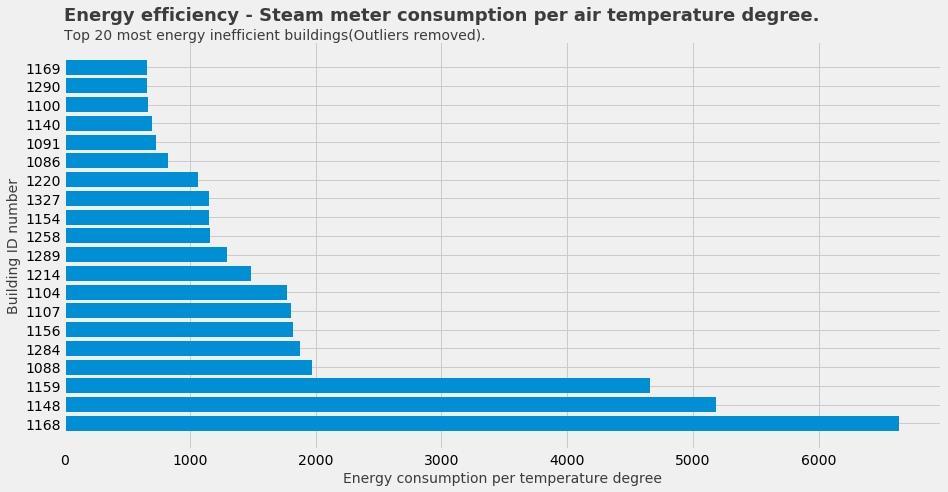

In [26]:
fig, ax = plt.subplots(figsize=(14,7))

ee_steam = ee[ee.index.get_level_values("meter")  == "Steam"]

plt.barh(ee_steam.index.get_level_values("building_id")[1:21].astype("str"),ee_steam["mean"][1:21])

plt.xlabel("Energy consumption per temperature degree", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

#Title

ax.text(x=0,y=21.5,s="Energy efficiency - Steam meter consumption per air temperature degree.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.5,s="Top 20 most energy inefficient buildings(Outliers removed).", fontsize="14",alpha=0.75)

gc.collect()

del ee_steam

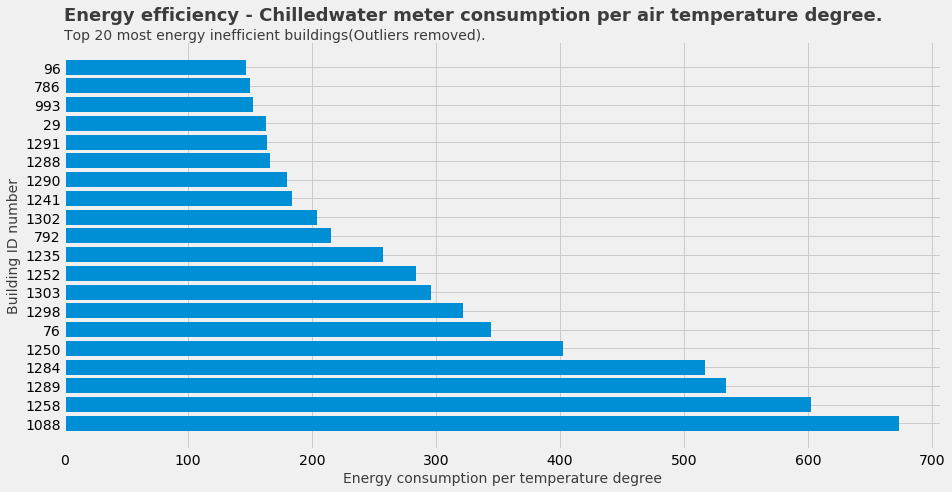

In [27]:
fig, ax = plt.subplots(figsize=(14,7))

ee_chill = ee[ee.index.get_level_values("meter")  == "Chilledwater"]

plt.barh(ee_chill.index.get_level_values("building_id")[1:21].astype("str"),ee_chill["mean"][1:21])

plt.xlabel("Energy consumption per temperature degree", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

#Title

ax.text(x=0,y=21.5,s="Energy efficiency - Chilledwater meter consumption per air temperature degree.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.5,s="Top 20 most energy inefficient buildings(Outliers removed).", fontsize="14",alpha=0.75)

gc.collect()

del ee_chill

4535

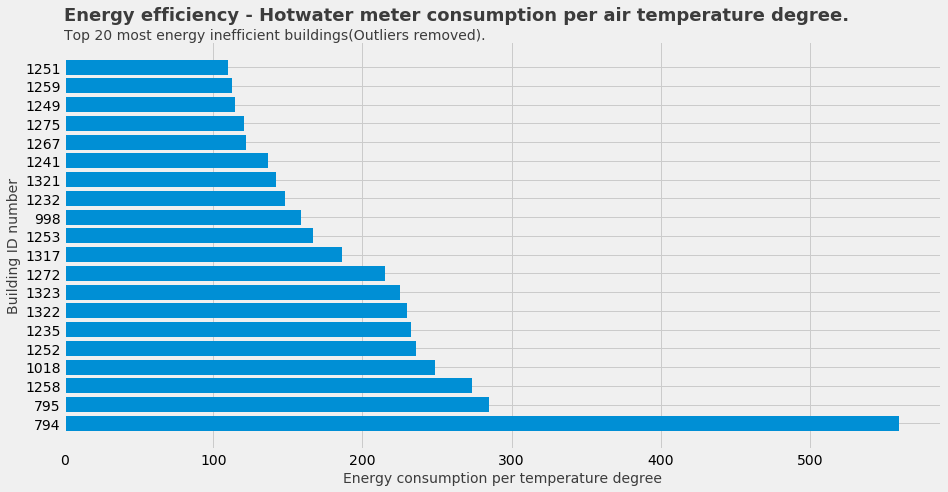

In [28]:
fig, ax = plt.subplots(figsize=(14,7))

ee_hot = ee[ee.index.get_level_values("meter")  == "Hotwater"]

plt.barh(ee_hot.index.get_level_values("building_id")[2:22].astype("str"),ee_hot["mean"][2:22])

plt.xlabel("Energy consumption per temperature degree", fontsize=14, alpha=0.75)
plt.ylabel("Building ID number",fontsize=14, alpha=0.75)

#Title

ax.text(x=0,y=21.5,s="Energy efficiency - Hotwater meter consumption per air temperature degree.", weight="bold", fontsize="18",alpha=0.75)
ax.text(x=0,y=20.5,s="Top 20 most energy inefficient buildings(Outliers removed).", fontsize="14",alpha=0.75)

del ee_hot
gc.collect()

**<a id="7"> Linear correlations </a>**

Checking for linear correlation between the feature is a good practice. However, the heterogenic nature of the dataset I mentioned previously is most likely going to cause issues.

In [29]:
df_heatmap =  df_train_clean.select_dtypes("number")
df_heatmap.drop(["site_id", "building_id"], axis=1,inplace=True)

test = df_heatmap.corr()

gc.collect()
del df_heatmap

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


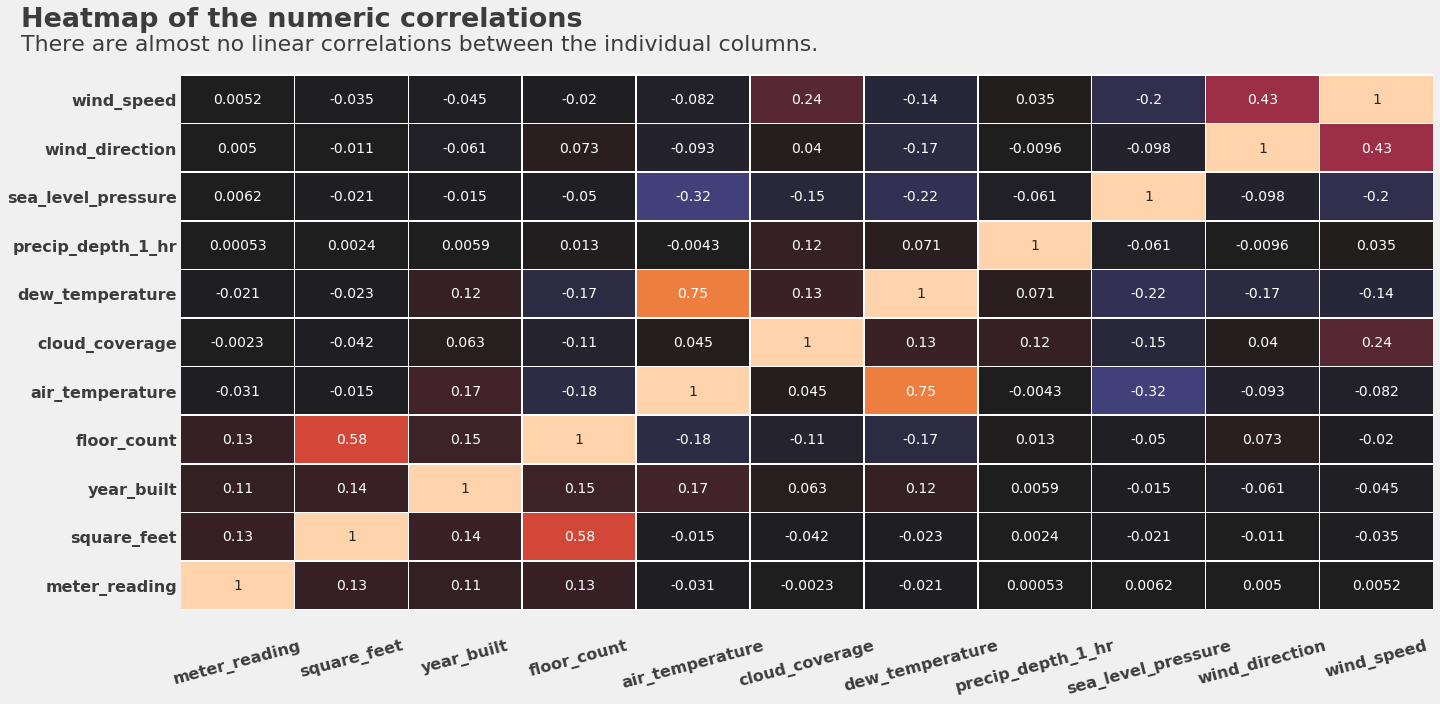

In [30]:
ax, fig = plt.subplots(figsize=(20,10))

ax = sns.heatmap(test,annot=True,annot_kws={"size": 14},linewidths=.5,center=0,cbar=False)

plt.xticks(rotation=15,weight="bold", fontsize=16, alpha=0.75)
plt.yticks(weight="bold", fontsize=16, alpha=0.75)

bottom, top = plt.ylim()
ax.set_ylim(top - 0.5 , bottom + 0.5)

#Title
plt.text(x=-1.4,y=12,s="Heatmap of the numeric correlations", weight="bold",alpha=0.75, fontsize=27)
plt.text(x=-1.4,y=11.5,s="There are almost no linear correlations between the individual columns.",alpha=0.75, fontsize=22)

plt.savefig("corr.png")

gc.collect()

del test

There is some correlation between the features, but overall the linear correlation heatmap is not saying much. The obvious correlation is that of square feet and numbers of floors (who would have guessed) and air and dew temperature. However, this was more or less expected as the dataset has a few columns of categorical data and its unreasonable to expect each category to behave the same.

 The exploration of dependencies within categories needs a different approach that has whiskers - the box and whiskers plot

**<a id="8" > 🐱 Categorical differences in energy usage </a>**

Box plots are a great non-parametric way of analysing the same feature with different categories in mind. They also offer a wide range of information from the mean to potential outliers in the data.

In [31]:
df_train_clean["log_meter"] = np.log1p(df_train_clean["meter_reading"])

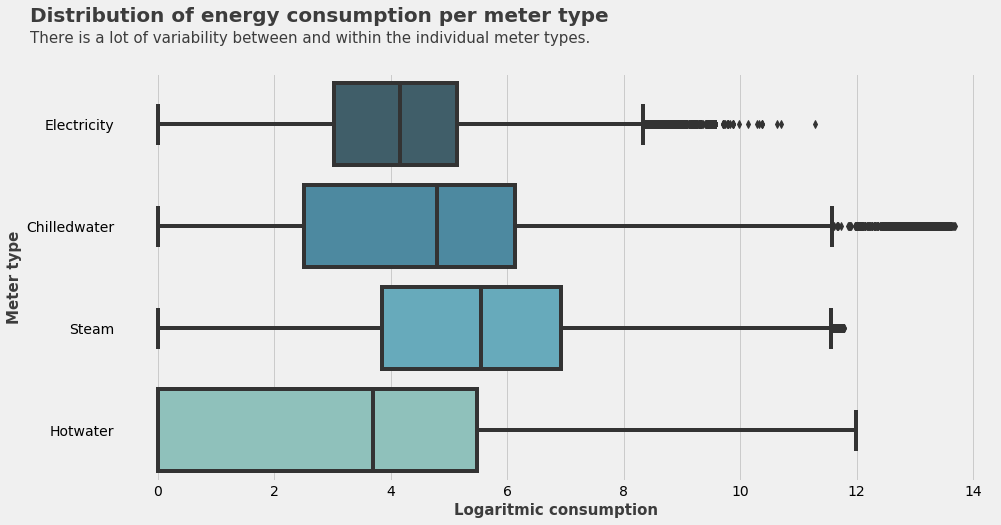

In [32]:
ax, fig = plt.subplots(figsize=(14,7))

sns.boxplot(y="meter", x="log_meter",palette="GnBu_d",data=df_train_clean)

plt.xlabel("Logaritmic consumption",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("Meter type",weight="bold", alpha=0.75, fontsize=15)

#Ttile

plt.text(x=-2.2,y=-1,s="Distribution of energy consumption per meter type", weight="bold",fontsize=20,alpha=0.75)
plt.text(x=-2.2,y=-0.8,s="There is a lot of variability between and within the individual meter types.",fontsize=15,alpha=0.75)

plt.savefig("box_meter.png")

Steam is most definitely the largest consumer of electricity. While Chilled water and Electricity seam to have the most potential outliers. The whiskers long range also indicates that there is a lot of variety in consumption for all meters.

Text(-1.7, -1.05, 'The categorization is based on the construction decade of the buildings.')

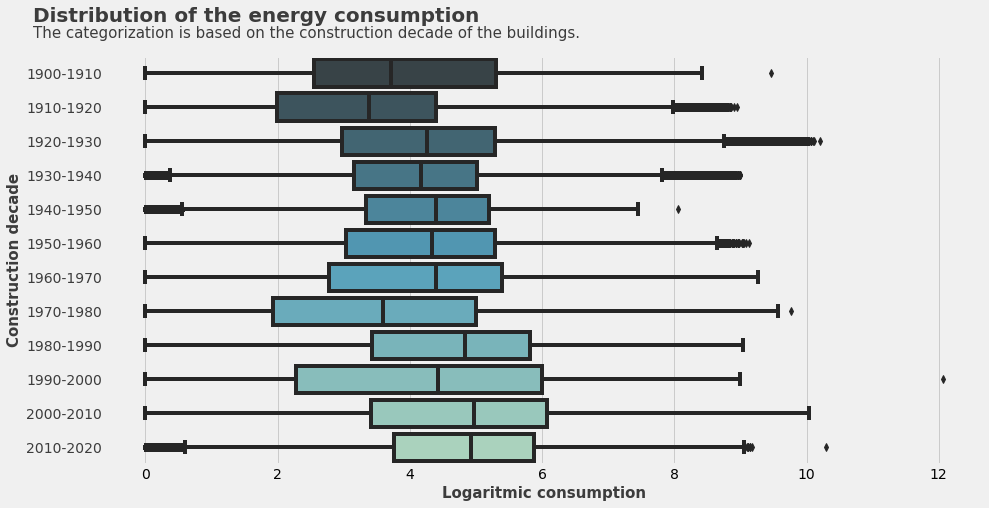

In [33]:
ax, fig = plt.subplots(figsize=(14,7))

bins = [1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
df_train_clean["binns"] = pd.cut(df_train_clean["year_built"], bins)

ax = sns.boxplot(y="binns", x="log_meter",palette="GnBu_d",data=df_train_clean)

plt.xlabel("Logaritmic consumption",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("Construction decade",weight="bold", alpha=0.75, fontsize=15)

ax.set_yticklabels(["1900-1910","1910-1920","1920-1930","1930-1940","1940-1950","1950-1960","1960-1970","1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"], alpha=0.75)

#Title
plt.text(x=-1.7,y=-1.5,s="Distribution of the energy consumption", weight="bold",fontsize=20,alpha=0.75)
plt.text(x=-1.7,y=-1.05,s="The categorization is based on the construction decade of the buildings.",fontsize=15,alpha=0.75)

My initial hypothesis for this plot was an increased consumption for the early construction dates. The logic behind this assumption is that the modern construction and isolation methods would greatly surpass old standards and in turn result in less consumption. However, this was a one-sided approach on my part. The isolation of the older buildings might be worse, but the main reason behind the data we see above is the size of the buildings. Modern buildings are much larger in comparison to the buildings made over a century ago.

Text(-4.2, -0.8, 'Again, there is a lot of variability between and within the individual types.There are also many more outliers than in the previous boxplot.')

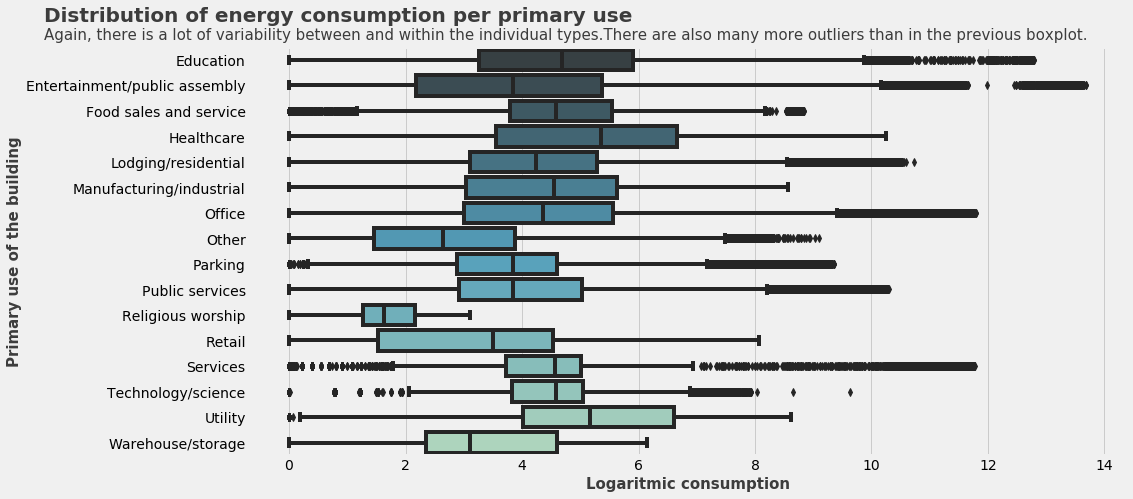

In [34]:
ax, fig = plt.subplots(figsize=(14,7))

ax = sns.boxplot(y="primary_use", x="log_meter",palette="GnBu_d",data=df_train_clean)

plt.xlabel("Logaritmic consumption",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("Primary use of the building",weight="bold", alpha=0.75, fontsize=15)

#Title
plt.text(x=-4.2,y=-1.5,s="Distribution of energy consumption per primary use", weight="bold",fontsize=20,alpha=0.75)
plt.text(x=-4.2,y=-0.8,s="Again, there is a lot of variability between and within the individual types.There are also many more outliers than in the previous boxplot.",fontsize=15,alpha=0.75)


Like I mentioned previously, primary-use is a very broad term. This just means that the main consumer of electricity operates in that industry and it isn't taking into account the other tenants. To add to the confusion, the industry descriptions like "Service" are also very broad with a lot of variety between the individual service industry branches.

In [35]:
df_train_clean.reset_index(inplace=True)
df_train_clean["timestamp"] = pd.to_datetime(df_train_clean["timestamp"])
df_train_clean["dayofweek"] = df_train_clean["timestamp"].dt.day_name()
df_train_clean["Month"] = df_train_clean["timestamp"].dt.month
df_train_clean["Hour"] = df_train_clean["timestamp"].dt.hour

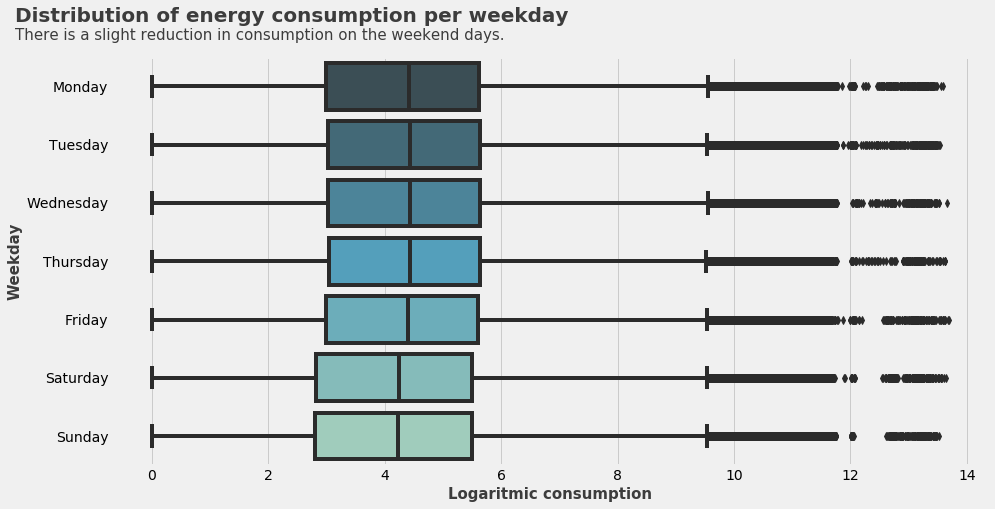

In [36]:
ax, fig = plt.subplots(figsize=(14,7))

#Data
order_of_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

#Plot
ax = sns.boxplot(y="dayofweek", x="log_meter",palette="GnBu_d",data=df_train_clean,order=order_of_days)

plt.xlabel("Logaritmic consumption",weight="bold", alpha=0.75, fontsize=15)
plt.ylabel("Weekday",weight="bold", alpha=0.75, fontsize=15)

#Title
plt.text(x=-2.35,y=-1.1,s="Distribution of energy consumption per weekday", weight="bold",fontsize=20,alpha=0.75)
plt.text(x=-2.35,y=-0.8,s="There is a slight reduction in consumption on the weekend days.",fontsize=15,alpha=0.75)

gc.collect()
del order_of_days

The last of the famous box and whiskers plots. I initially expected to see a larger difference in the mean consumptions between the workdays and non-workdays. There is a small dip, but its nothing substantial.

**<a id="9">Building data analysis</a>**

This segment will be geared towards looking at the building metadata that was handed to us. I will take a look at the number of sites and the buildings within those sites and the construction date distribution of the dataset. 

5930

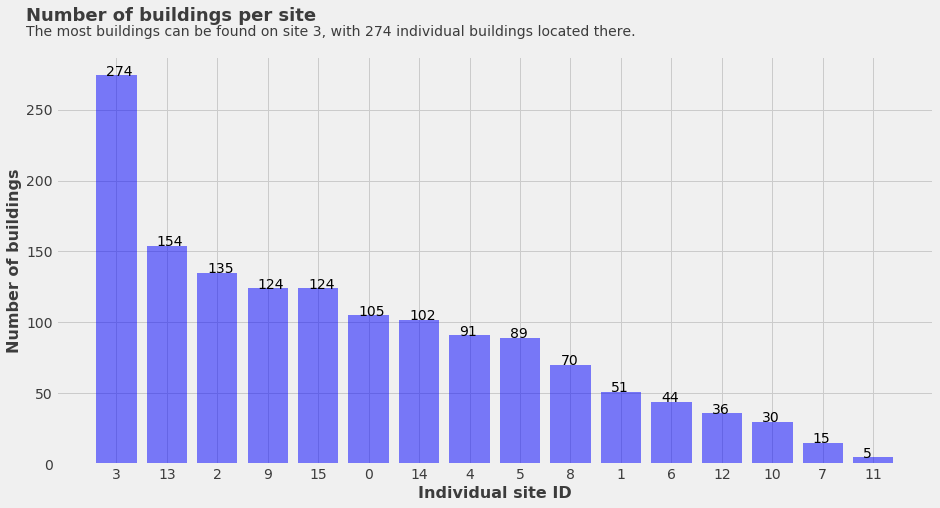

In [37]:
ax, fig = plt.subplots(figsize=(14,7))

#Data
count_building_id = df_train_clean.groupby("site_id")["building_id"].nunique()
count_building_id = count_building_id.reset_index()
count_building_id.sort_values(by="building_id",ascending=False,inplace=True)

#Plot
bars = plt.bar(count_building_id["site_id"].astype("str"),count_building_id["building_id"],color="blue",alpha=0.5)
plt.xticks(alpha=0.75)
plt.yticks(alpha=0.75)
plt.xlabel("Individual site ID", alpha=0.75, weight="bold", fontsize=16)
plt.ylabel("Number of buildings", alpha=0.75, weight="bold", fontsize=16)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.20, yval + .015, yval, color = "black")
    
#Title
ax.text(x=0.05,y=0.95,s="Number of buildings per site", weight="bold",fontsize=18,alpha=0.75)
ax.text(x=0.05,y=0.92,s="The most buildings can be found on site 3, with 274 individual buildings located there.",fontsize=14,alpha=0.75)

#plt.savefig("building_per_site.png")

del count_building_id
gc.collect()

Considering the ASHRAE is a primary American company, we can assume that the sites with the most buildings are in the US. The sites that belong in the lower 50% could potentially be from other parts of the world since ASHRAE has a global outreach.

Text(0.08, 0.92, 'The distribution of construction years on the training dataset.')

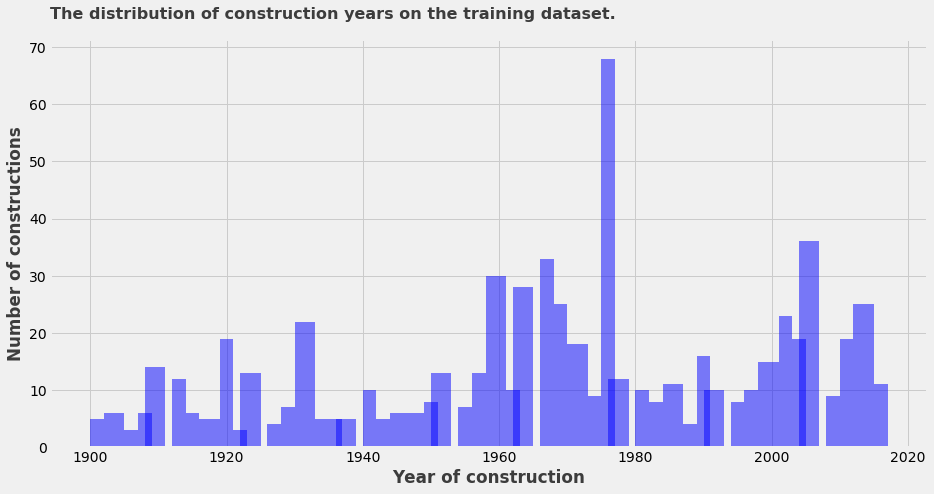

In [38]:
ax, fig = plt.subplots(figsize=(14,7))

#Data
build_date = df_train_clean.groupby("building_id").agg({"meter_reading" : "mean", "year_built" : "max"})

#Plot

plt.hist(build_date["year_built"], bins=50,color = "blue", alpha=0.5)

plt.xlabel("Year of construction", alpha=0.75, weight="bold")
plt.ylabel("Number of constructions", alpha=0.75, weight="bold")

#Title

ax.text(x=0.08, y=0.92,s="The distribution of construction years on the training dataset.", weight="bold",fontsize=16,alpha=0.75)

In [39]:
#df_train_clean.set_index(df_train_clean["timestamp"],inplace=True)

**<a id="10" > Temperature data analysis </a>**

In [40]:
#Temp dataset
temp_df = df_train_clean[["timestamp","site_id","air_temperature"]]

#Droping duplicates
key = ["timestamp","site_id"]
temp_df = temp_df[key + ["air_temperature"]].drop_duplicates(subset=key)

#Sorting values and extracting hours
temp_df = temp_df.sort_values(by=key)
temp_df["Hour"] = temp_df.timestamp.dt.hour

#Groupby mean and unstack
g_temp = temp_df.groupby(["site_id","Hour"])["air_temperature"].agg(["mean"]).unstack(level=1)

#Divide the column temperatures by the row max
g_temp = g_temp / g_temp.max(axis=1).values.reshape((-1,1))  

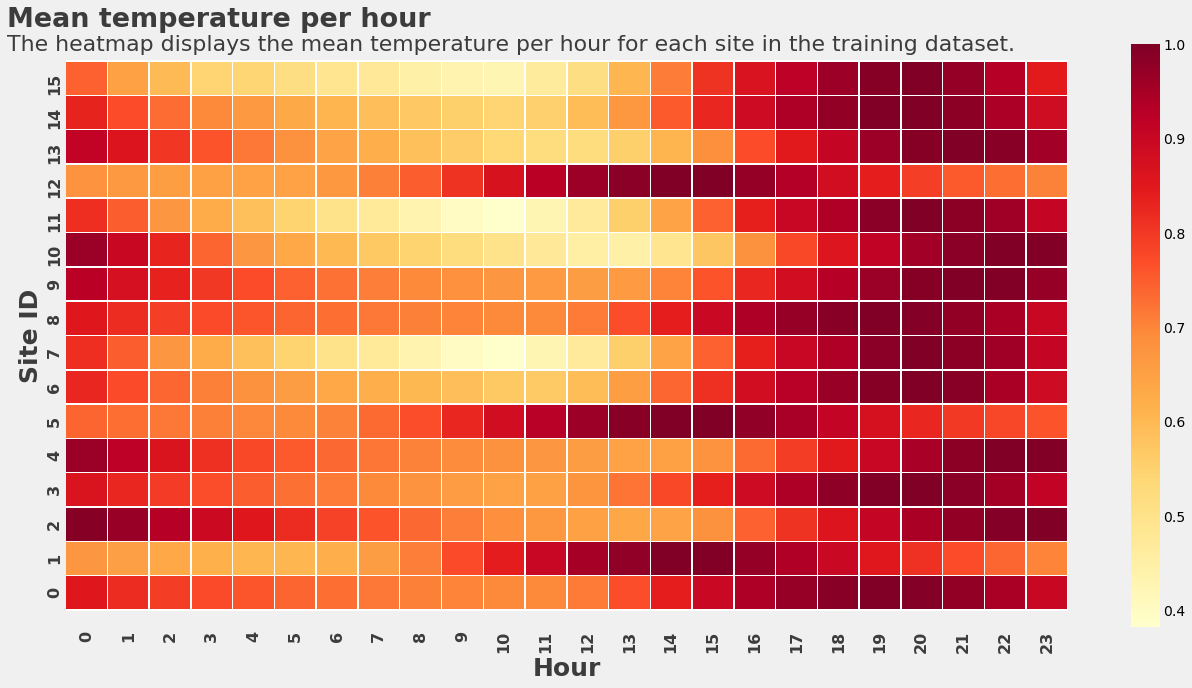

In [41]:
ax, fig = plt.subplots(figsize=(20,10))

ax = sns.heatmap(g_temp,linewidths=.5,cmap="YlOrRd")

ax.set_xticklabels(np.arange(0,24).astype("str"))

plt.xticks(weight="bold", fontsize=16, alpha=0.75)
plt.yticks(weight="bold", fontsize=16, alpha=0.75)

plt.xlabel("Hour",weight="bold", fontsize=25,alpha=0.75)
plt.ylabel("Site ID",weight="bold", fontsize=25,alpha=0.75)

bottom, top = plt.ylim()
ax.set_ylim(top - 0.5 , bottom + 0.5)

#Title
plt.text(x=-1.4,y=17,s="Mean temperature per hour", weight="bold",alpha=0.75, fontsize=27)
plt.text(x=-1.4,y=16.3,s="The heatmap displays the mean temperature per hour for each site in the training dataset.",alpha=0.75, fontsize=22)


gc.collect()

del g_temp, temp_df

The heatmap above represents the average hourly temperature for each site in the training dataset.  To properly compare the sites I have divided each mean by the maximum amount of the site. This allows for a better visual presentation of the data and overall quality.

The first thing that is immediately noticeable is that some of the sits don't align well with the rest of the data with their peak temperatures. Peak temperature misalignment can happen due to location differences, problems with timezone settings, etc. This is definitely a topic to research further.

The following plots will contain data on how each individual meter interacts with air temperature.

In [42]:
df_train_clean.set_index(df_train_clean["timestamp"],inplace=True)
#df_train_clean.drop("timstamp",axis=1,inplace=True)

5647

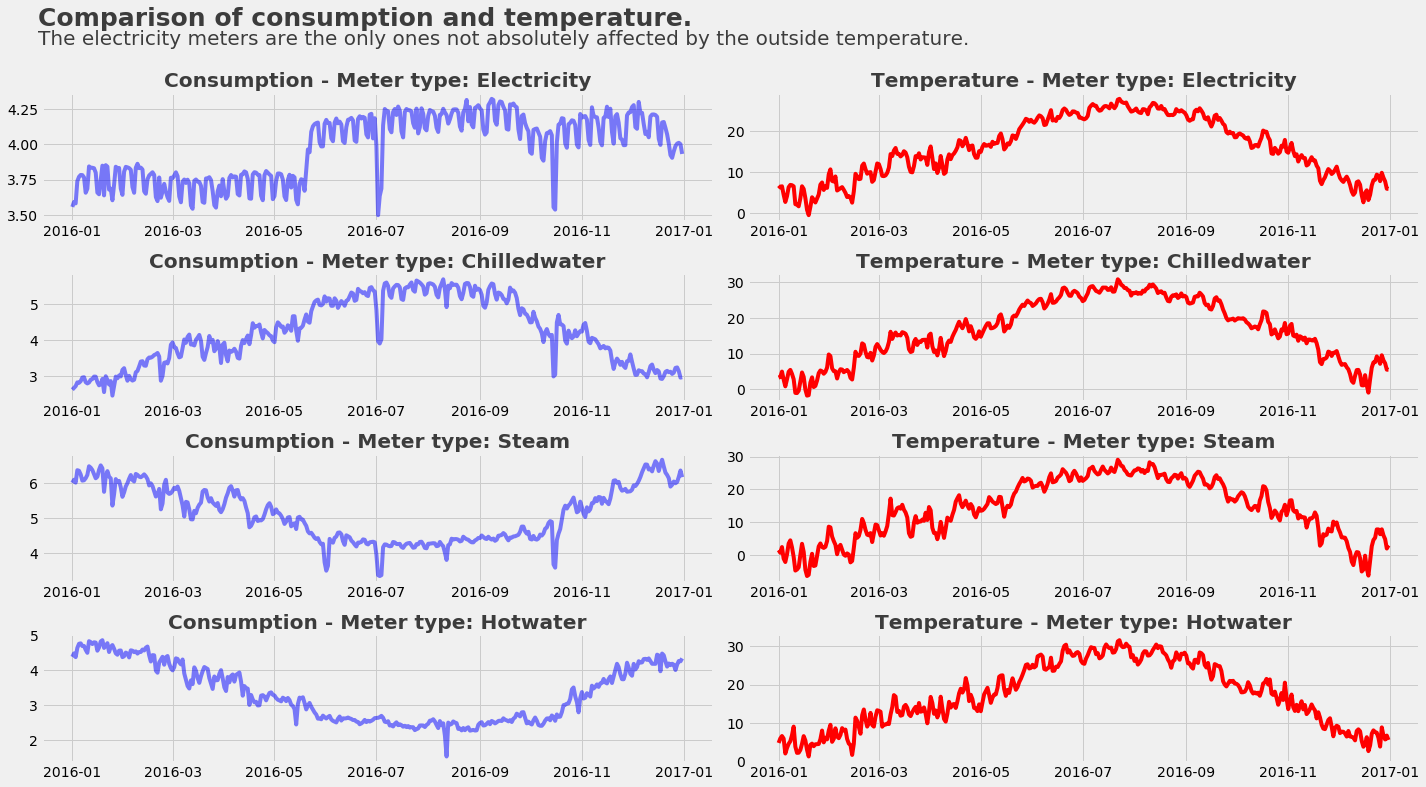

In [43]:
i = 0
m_types = df_train_clean["meter"].unique()

fig,ax = plt.subplots(figsize=(20,20))

for meter in m_types:
    i+=1
    meter_type = df_train_clean[df_train_clean["meter"] == meter]["log_meter"].resample("D").mean()
    plt.subplot(8,2,i)
    plt.plot(meter_type,color="blue",alpha=0.5)
    plt.title("Consumption - Meter type: {}".format(meter), weight="bold", alpha=0.75)
    
    i+=1
    weather_data = df_train_clean[df_train_clean["meter"] == meter]["air_temperature"].resample("D").mean()
    plt.subplot(8,2,i)
    plt.plot(weather_data, color = "red")
    plt.title("Temperature - Meter type: {}".format(meter), weight="bold", alpha=0.75)
    plt.tight_layout(pad=1)
    
plt.text(x=dt.date(2014, 10, 15),y=192,s="Comparison of consumption and temperature.",weight="bold",fontsize=25,alpha=0.75)
plt.text(x=dt.date(2014, 10, 15),y=187,s="The electricity meters are the only ones not absolutely affected by the outside temperature.",fontsize=20,alpha=0.75)

#plt.savefig("consumption_vs_temperature.png")

del meter_type, m_types, weather_data

gc.collect()

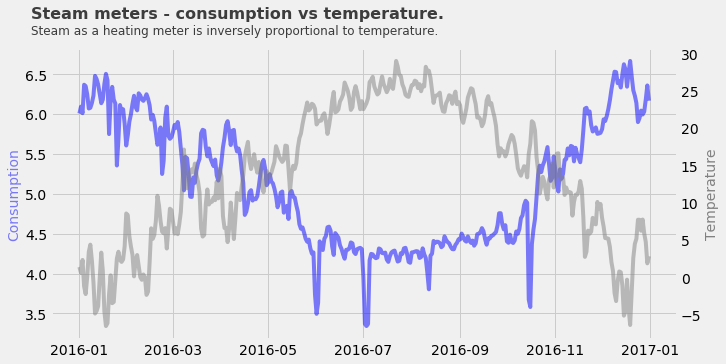

In [44]:
fig,ax = plt.subplots(figsize=(10,5))

meter_type = df_train_clean[df_train_clean["meter"] == "Steam"]["log_meter"].resample("D").mean()
weather_data = df_train_clean[df_train_clean["meter"] == "Steam"]["air_temperature"].resample("D").mean()

ax.plot(meter_type, color="blue",alpha=0.5)
ax.set_ylabel("Consumption",color="blue",alpha=0.5,fontsize=14)
#ax.grid(False)

ax2=ax.twinx()
ax2.plot(weather_data,color="grey",alpha=0.5)
ax2.set_ylabel("Temperature",color="grey",fontsize=14)
ax2.grid(False)
#plt.title("Steam Meter : Consumption vs Temperature")

#Title
ax.text(x=dt.date(2015, 12, 1),y=7.2,s="Steam meters - consumption vs temperature.",weight="bold",fontsize=16,alpha=0.75)
ax.text(x=dt.date(2015, 12, 1),y=7.0,s="Steam as a heating meter is inversely proportional to temperature.",fontsize=12,alpha=0.75)
#plt.savefig("steam_vs_temp.png")

del meter_type, weather_data

Text(2015-12-01, 4.45, 'Electricity meters have some correlation with the temperature data, but it needs to be researched further.')

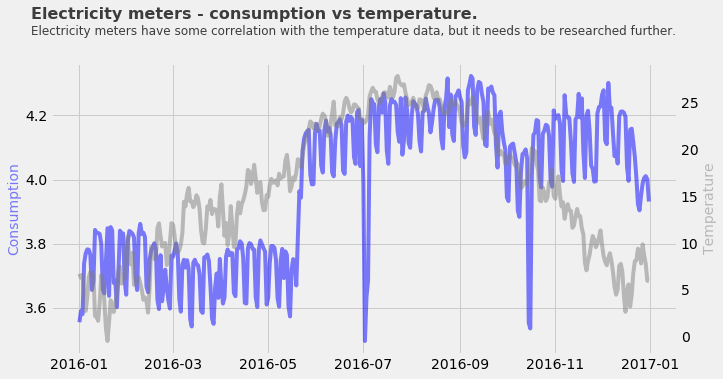

In [45]:
fig,ax = plt.subplots(figsize=(10,5))

#Data
meter_type = df_train_clean[df_train_clean["meter"] == "Electricity"]["log_meter"].resample("D").mean()
weather_data = df_train_clean[df_train_clean["meter"] == "Electricity"]["air_temperature"].resample("D").mean()

#Plot
ax.plot(meter_type, color="blue",alpha=0.5)
ax.set_ylabel("Consumption",color="blue",alpha=0.5,fontsize=14)

ax2=ax.twinx()
ax2.plot(weather_data,color="grey",alpha=0.5)
ax2.set_ylabel("Temperature",color="grey",alpha=0.5,fontsize=14)
ax2.grid(False)

#Title
ax.text(x=dt.date(2015, 12, 1),y=4.5,s="Electricity meters - consumption vs temperature.",weight="bold",fontsize=16,alpha=0.75)
ax.text(x=dt.date(2015, 12, 1),y=4.45,s="Electricity meters have some correlation with the temperature data, but it needs to be researched further.",fontsize=12,alpha=0.75)
#plt.savefig("steam_vs_temp.png")


22582

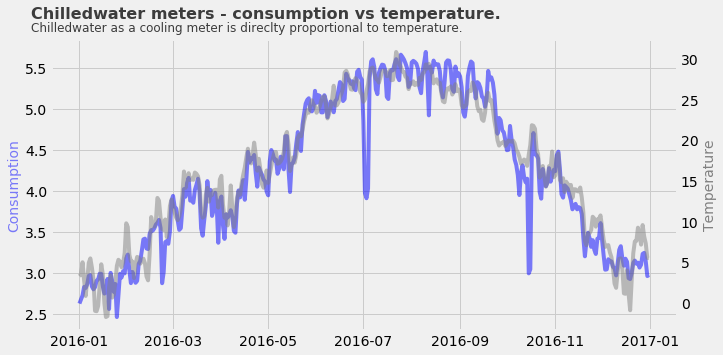

In [46]:
fig,ax = plt.subplots(figsize=(10,5))

#Data
meter_type = df_train_clean[df_train_clean["meter"] == "Chilledwater"]["log_meter"].resample("D").mean()
weather_data = df_train_clean[df_train_clean["meter"] == "Chilledwater"]["air_temperature"].resample("D").mean()
#Plot
ax.plot(meter_type, color="blue",alpha=0.5)
ax.set_ylabel("Consumption",color="blue",alpha=0.5,fontsize=14)

ax2=ax.twinx()
ax2.plot(weather_data,color="grey",alpha=0.5)
ax2.set_ylabel("Temperature",color="grey",fontsize=14)
ax2.grid(False)

#Title
ax.text(x=dt.date(2015, 12, 1),y=6.1,s="Chilledwater meters - consumption vs temperature.",weight="bold",fontsize=16,alpha=0.75)
ax.text(x=dt.date(2015, 12, 1),y=5.95,s="Chilledwater as a cooling meter is direclty proportional to temperature.",fontsize=12,alpha=0.75)

del meter_type, weather_data
gc.collect()

4356

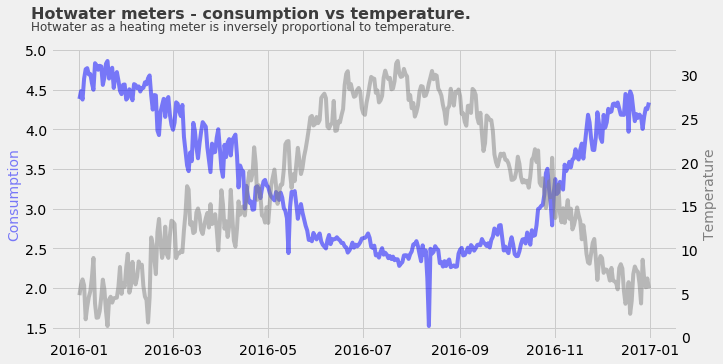

In [47]:
fig,ax = plt.subplots(figsize=(10,5))

#Data
meter_type = df_train_clean[df_train_clean["meter"] == "Hotwater"]["log_meter"].resample("D").mean()
weather_data = df_train_clean[df_train_clean["meter"] == "Hotwater"]["air_temperature"].resample("D").mean()

#Plot
ax.plot(meter_type, color="blue",alpha=0.5)
ax.set_ylabel("Consumption",color="blue",alpha=0.5,fontsize=14)

ax2=ax.twinx()
ax2.plot(weather_data,color="grey",alpha=0.5)
ax2.set_ylabel("Temperature",color="grey",fontsize=14)
ax2.grid(False)

#Title
ax.text(x=dt.date(2015, 12, 1),y=5.4,s="Hotwater meters - consumption vs temperature.",weight="bold",fontsize=16,alpha=0.75)
ax.text(x=dt.date(2015, 12, 1),y=5.25,s="Hotwater as a heating meter is inversely proportional to temperature.",fontsize=12,alpha=0.75)

del meter_type,weather_data
gc.collect()

**<a id=11> Final words <a/>**

Generally speaking, this notebook only scratches the surface of a topic as deep as energy usage. There are many more additions that can be made, especially regarding other the relationship between temperature and consumption.

Hopefully, I have managed to offer a somewhat new perspective of the dataset and I hope that it was of some use for you. Regarding the future of the notebook, I always tend to come back to my earlier works and apply some new knowledge to them so that updates can be expected.


Cheers,

O.G.